In [1]:
#General packages
import numpy as np
import pandas as pd
from pymongo import MongoClient
from tqdm import tqdm
from scipy import stats
import statsmodels.api as sm

#Figure packages
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import plotly.express as px
import plotly.io as pio
import matplotlib.ticker as ticker

#custom packages
import query_builder
import grocery_base

### Figure display properties

In [2]:
def set_fonts(font_size =12, font_scale=1.5):
    SMALL_SIZE = font_size
    MEDIUM_SIZE = font_size
    BIGGER_SIZE = font_size

    plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    matplotlib.rcParams['font.serif'] = "Times New Roman"
    matplotlib.rcParams['font.family'] = "serif"
    sns.set_style({'font.family': 'serif', 'font.serif': 'Times New Roman'})
    sns.set(style="ticks", font="Times New Roman", font_scale=font_scale)

    #https://songhuiming.github.io/pages/2017/04/02/jupyter-and-pandas-display/
    pd.set_option('display.max_rows', 500)
    pd.set_option('display.max_columns', 150)
    pd.set_option('display.max_colwidth', 0)

set_fonts()

display(HTML("<style>.container { width:85% !important; }</style>"))

# Load and Process Data

In [3]:
gdb_df=pd.read_csv('GroceryDB_foods.csv')
print(len(gdb_df))

50468


In [4]:
#Only keep items with FPro score and Nutrients converted to g/100g
gdb_conv_df = gdb_df[(gdb_df['is_Nuts_Converted_100g'] == 1) & (~gdb_df['f_min_FPro'].isnull())].reset_index(drop=True)
print(len(gdb_conv_df))

26250


In [5]:
gdb_conv_df['harmonized single category'] = gdb_conv_df['harmonized single category'].fillna('NONE')

category_stat = gdb_conv_df.groupby('harmonized single category').agg(count_products_category = ('original_ID', np.size)).reset_index()

gdb_conv_df = pd.merge(
    category_stat,
    gdb_conv_df,
    on='harmonized single category')

print(len(gdb_conv_df))

26250


In [6]:
cats_ignore_analysis = {
    'coffee-beans-wf',
    'drink-juice-wf',
    'drink-water-wf',
    'eggs-wf',
    'exempt',
    'find-category',
    'maybe-bug', # includes products that stores did not provide correct nutrition facts
    'meat-poultry-wf',
    'no-category', # products that we were not able to assign to any category
    'nuts-seeds-wf',
    'produce-beans-wf',
    'rice-grains-wf',
    'seafood-wf',
}

print('Number of categories will be included in the analysis: {} from {}'.format(
    len(category_stat[~category_stat['harmonized single category'].isin(cats_ignore_analysis)]),
    len(category_stat)
))


'''DECIDE IF YOU WANNA KEEP UNPROCESSED ITEMS IN THE ANALYSIS'''

column_category = 'harmonized single category'
if True:
    print('Number of items INCLUDING exempt categories: ', len(gdb_conv_df))
    gdb_conv_df = gdb_conv_df[~gdb_conv_df[column_category].isin(cats_ignore_analysis)].reset_index(drop=True)
    print('Number of items AFTER REMOVING exempt categories: ', len(gdb_conv_df))
    
print('We use gdb_df to analyze all GroceryDB and gdb_conv_df for FPro analysis')

Number of categories will be included in the analysis: 43 from 52
Number of items INCLUDING exempt categories:  26250
Number of items AFTER REMOVING exempt categories:  24142
We use gdb_df to analyze all GroceryDB and gdb_conv_df for FPro analysis


# Figure 2b

Num categories: 42


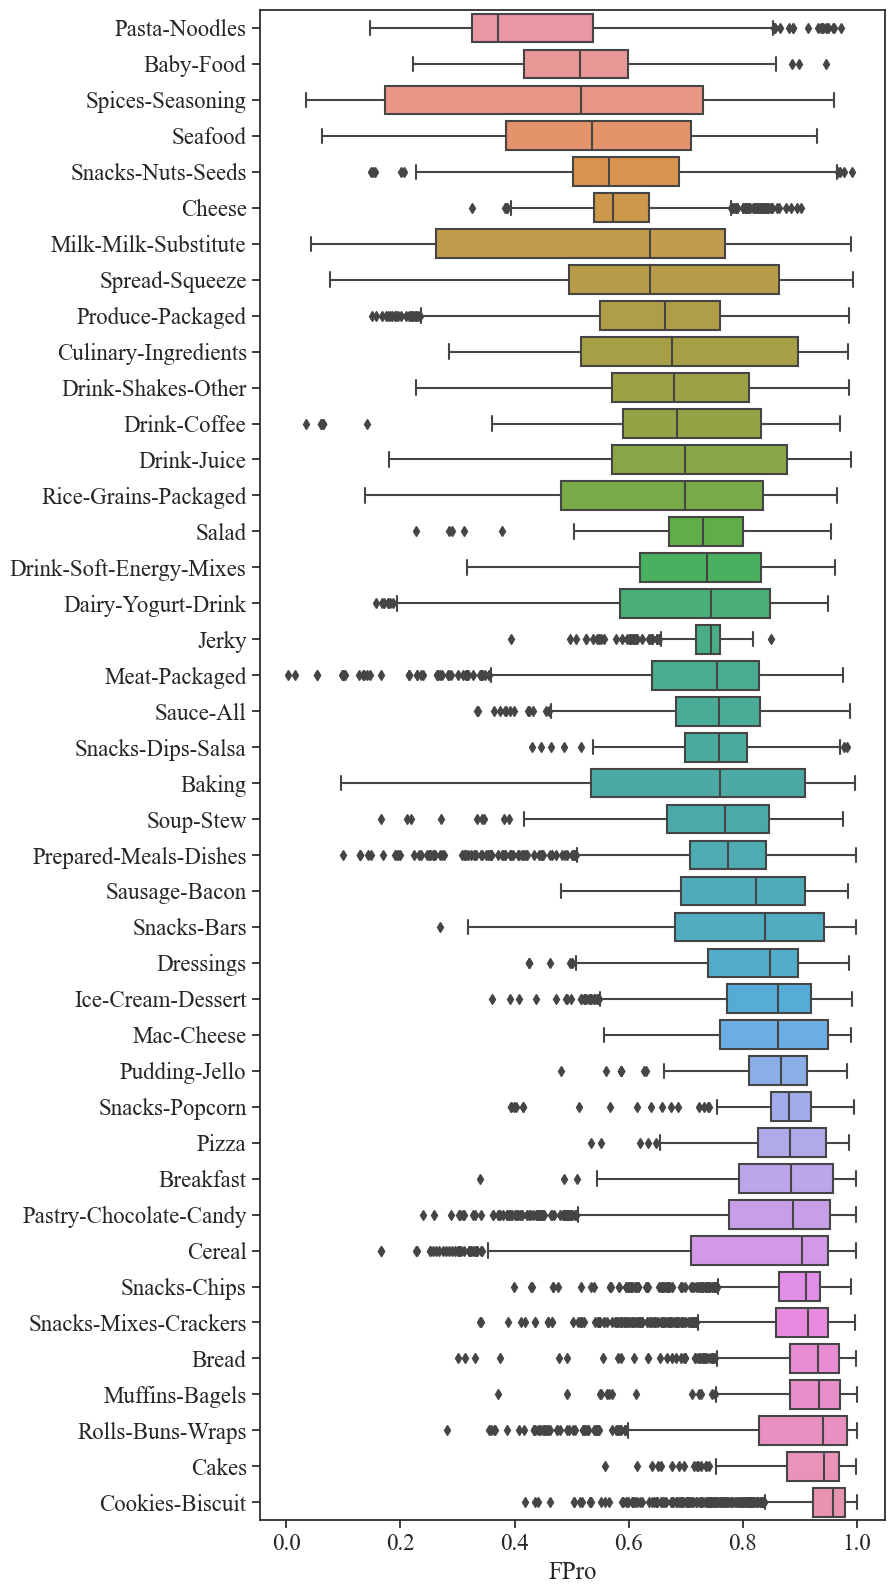

In [7]:
'''Categories with less than 100 products are not shown'''
cat_count_cutoff = 100

gdb_2b=gdb_conv_df[(gdb_conv_df['count_products_category'] > cat_count_cutoff) 
            & (~(gdb_conv_df['harmonized single category'].str.lower().isin(cats_ignore_analysis)))]
#gdb_2b=gdb_2b[~(gdb_2b['harmonized single category']=='pasta-noodles')] #remove category due to bimodal distribution

ax, cat_stats = grocery_base.plot_all_categories_FPro(
    gdb_2b, 
    col_FPro="f_FPro", col_category='harmonized single category', font_scale=1.5, figsize = (9, 16),
    verbose=False,
    export_path='output/fig2B.pdf'
)

In [8]:
cat_stats

harmonized single category  FPro_median  count_products  \
0   Pasta-Noodles              0.371611     253              
1   Baby-Food                  0.514591     126              
2   Spices-Seasoning           0.516371     232              
3   Seafood                    0.536203     372              
4   Snacks-Nuts-Seeds          0.565722     357              
5   Cheese                     0.573152     1011             
6   Milk-Milk-Substitute       0.636419     402              
7   Spread-Squeeze             0.636889     301              
8   Produce-Packaged           0.663028     1107             
9   Culinary-Ingredients       0.674978     194              
10  Drink-Shakes-Other         0.679937     309              
11  Drink-Coffee               0.684122     223              
12  Drink-Juice                0.698171     391              
13  Rice-Grains-Packaged       0.698968     128              
14  Salad                      0.730111     135              
15  Drink-Soft-Energy-Mixes    0.737159     136              
16  Dairy-Yogurt-Drink         0.743700     831              
17  Jerky                      0.744722     238              
18  Meat-Packaged              0.753722     898              
19  Sauce-All                  0.757472     662              
20  Snacks-Dips-Salsa          0.758257     453              
21  Baking                     0.760194     382              
22  Soup-Stew                  0.767745     622              
23  Prepared-Meals-Dishes      0.774333     2043             
24  Sausage-Bacon              0.823329     466              
25  Snacks-Bars                0.839417     1402             
26  Dressings                  0.847659     574              
27  Ice-Cream-Dessert          0.861222     907              
28  Mac-Cheese                 0.861306     212              
29  Pudding-Jello              0.867361     156              
30  Snacks-Popcorn             0.880491     208              
31  Pizza                      0.882222     372              
32  Breakfast                  0.885000     289              
33  Pastry-Chocolate-Candy     0.887389     1529             
34  Cereal                     0.903278     800              
35  Snacks-Chips               0.911194     978              
36  Snacks-Mixes-Crackers      0.914056     1116             
37  Bread                      0.931778     689              
38  Muffins-Bagels             0.932667     253              
39  Rolls-Buns-Wraps           0.940111     659              
40  Cakes                      0.941694     404              
41  Cookies-Biscuit            0.958389     1228             

                   cat_name  
0   Pasta-Noodles            
1   Baby-Food                
2   Spices-Seasoning         
3   Seafood                  
4   Snacks-Nuts-Seeds        
5   Cheese                   
6   Milk-Milk-Substitute     
7   Spread-Squeeze           
8   Produce-Packaged         
9   Culinary-Ingredients     
10  Drink-Shakes-Other       
11  Drink-Coffee             
12  Drink-Juice              
13  Rice-Grains-Packaged     
14  Salad                    
15  Drink-Soft-Energy-Mixes  
16  Dairy-Yogurt-Drink       
17  Jerky                    
18  Meat-Packaged            
19  Sauce-All                
20  Snacks-Dips-Salsa        
21  Baking                   
22  Soup-Stew                
23  Prepared-Meals-Dishes    
24  Sausage-Bacon            
25  Snacks-Bars              
26  Dressings                
27  Ice-Cream-Dessert        
28  Mac-Cheese               
29  Pudding-Jello            
30  Snacks-Popcorn           
31  Pizza                    
32  Breakfast                
33  Pastry-Chocolate-Candy   
34  Cereal                   
35  Snacks-Chips             
36  Snacks-Mixes-Crackers    
37  Bread                    
38  Muffins-Bagels           
39  Rolls-Buns-Wraps         
40  Cakes                    
41  Cookies-Biscuit

# Figure S3b

10 Nutrients Reported None
Missing Nutrients 0    6503 
2    8896 
4    10851
Name: count, dtype: int64


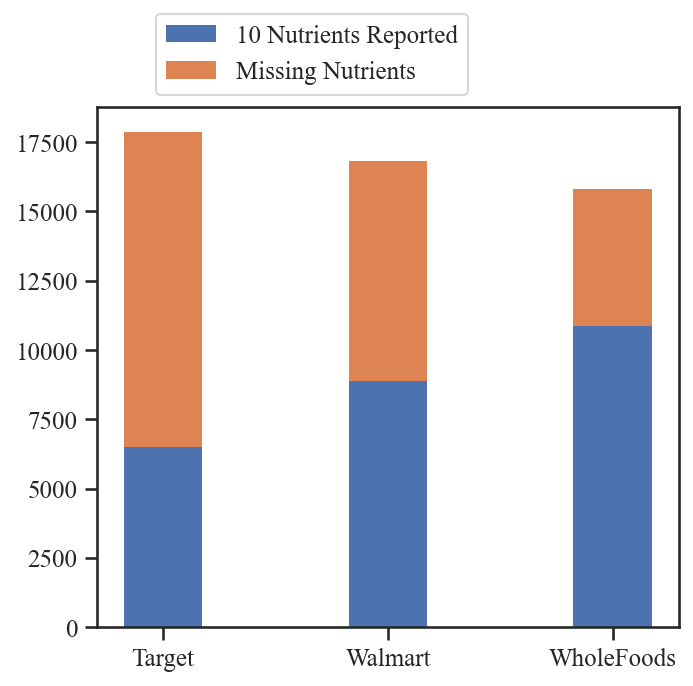

<module 'matplotlib.pyplot' from 'C:\\Users\\sobek\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [9]:
mask = (~gdb_df['f_min_FPro'].isnull()) & (gdb_df['is_Nuts_Converted_100g'] == 1)
gdb_df.loc[mask, 'status'] = '10 Nutrients Reported'
gdb_df.loc[~mask, 'status'] = 'Missing Nutrients'

gdb_classification_status_df = gdb_df.groupby(['store', 'status']).agg(count = ('original_ID', np.size)).reset_index()
gdb_classification_status_df

grocery_base.plot_bar_classified(gdb_classification_status_df,figsize=(5, 4.5), font_size=12)

# Figure S5

In [10]:
column_cat = 'harmonized single category'

gdb_select_df = [gdb_conv_df,gdb_df[~gdb_df[column_cat].str.lower().isin(['no-category', 'non-food', 'exempt'])]][0]
print('len(gdb_select_df):', len(gdb_select_df))

print('Column used for categories:', column_cat)

cat_df = (
    gdb_select_df.groupby(column_cat)
    .agg(count = ('original_ID', np.size)).reset_index()
    .rename(columns={column_cat: 'label'})
)

print('Sum products: {}'.format(cat_df['count'].sum()))

len(gdb_select_df): 24142
Column used for categories: harmonized single category
Sum products: 24142


In [11]:
fig = px.pie(
    cat_df, 
    values='count', 
    names='label',
    width=1200, height=1200
)

# https://plotly.github.io/plotly.py-docs/generated/plotly.graph_objects.Pie.html
fig.update_traces(
    textposition='inside', 
    textinfo='percent+label',
    texttemplate="%{label}:  %{percent}"
)

fig.update_layout(
    font_family=["Courier New", "Times New Roman"][1],
    font_size=25,
    showlegend=False,
)

#pio.write_image(fig, 'output/GroceryDB_categories_pie.png', width=800, height=800, scale=3)

fig

# PricePer Cal Category Corr-Map

In [12]:
column_cat = 'harmonized single category'

cat_df = pd.merge(
    gdb_df.groupby(column_cat).agg(count_selected_category = ('original_ID', np.size)).reset_index(),
    gdb_df[['original_ID', 'store', column_cat]],
    on=column_cat
)

### Filter GroceryDB to items with a Price Per Cal

In [13]:
column_cat = 'harmonized single category'
col_PricePerCal = 'price percal'

gdb_conv_PriceCal_df = gdb_conv_df.replace([np.inf, -np.inf], np.nan)
gdb_conv_PriceCal_df = gdb_conv_PriceCal_df[~gdb_conv_PriceCal_df[col_PricePerCal].isnull()]
gdb_conv_PriceCal_df = gdb_conv_PriceCal_df[gdb_conv_PriceCal_df['price percal'] < 0.1].reset_index(drop=True)
gdb_conv_PriceCal_df = gdb_conv_PriceCal_df[gdb_conv_PriceCal_df['package_weight'] < 1000].reset_index(drop=True)
gdb_conv_PriceCal_df = gdb_conv_PriceCal_df[(~gdb_conv_PriceCal_df['price percal'].isnull()) & (~gdb_conv_PriceCal_df['price percal'].isin([np.inf, -np.inf]))]

gdb_conv_PriceCal_df = pd.merge(
    gdb_conv_PriceCal_df.groupby(column_cat).agg(count_have_PricePerCal_category = ('original_ID', np.size)).reset_index(),
    gdb_conv_PriceCal_df,
    on=column_cat
)

gdb_conv_PriceCal_df = gdb_conv_PriceCal_df.sort_values(by=column_cat).reset_index(drop=True)

len(gdb_conv_PriceCal_df)

17887

### Calculate the Correlation between FPro and Price per Cal

In [14]:
col_FPro = 'f_FPro'

cat_corr_df = []

for cat in gdb_conv_PriceCal_df[
        gdb_conv_PriceCal_df['count_have_PricePerCal_category'] > 0
    ][column_cat].unique():
    
    cat_df = gdb_conv_PriceCal_df[gdb_conv_PriceCal_df[column_cat] == cat]
    
    cat_corr_dict = {
        'cat': cat,
        'count items': len(cat_df)#cat_df['count_have_PricePerCal_category'].unique()[0]
        
    }
    cat_corr_df.append(cat_corr_dict)
    
    corr, corr_pval = stats.spearmanr(cat_df[col_FPro], cat_df[col_PricePerCal])
    cat_corr_dict['All Stores'] = corr
    
    for store in grocery_base.stores:
        cat_store_df = cat_df[cat_df['store'] == store]
        cat_corr_dict[store] = None
        cat_corr_dict[store + ' count items'] = len(cat_store_df)
        
        if len(cat_store_df) > 10:
            corr, corr_pval = stats.spearmanr(cat_store_df[col_FPro], cat_store_df[col_PricePerCal])
            cat_corr_dict[store] = corr
            pass
        pass
    pass

cat_corr_df = pd.DataFrame(cat_corr_df).sort_values(by='All Stores')

if False:
    cat_corr_df.to_csv('GDB PricePerCal correlation FPro.csv')

cat_corr_df.head()

cat  count items  All Stores   Walmart  \
18  mac-cheese          178         -0.621110   -0.562416   
13  drink-shakes-other  95          -0.544816   -0.296014   
15  drink-tea           27          -0.534046   NaN         
40  soup-stew           478         -0.523435   -0.404704   
11  drink-coffee        109         -0.523374   -0.261525   

    Walmart count items    Target  Target count items  WholeFoods  \
18  71                  -0.641663  49                 -0.760062     
13  27                  -0.654821  32                 -0.513016     
15  8                   NaN        8                  -0.251142     
40  194                 -0.633186  87                 -0.383087     
11  44                  -0.239669  18                 -0.407924     

    WholeFoods count items  
18  58                      
13  36                      
15  11                      
40  197                     
11  47

# Figure S7c

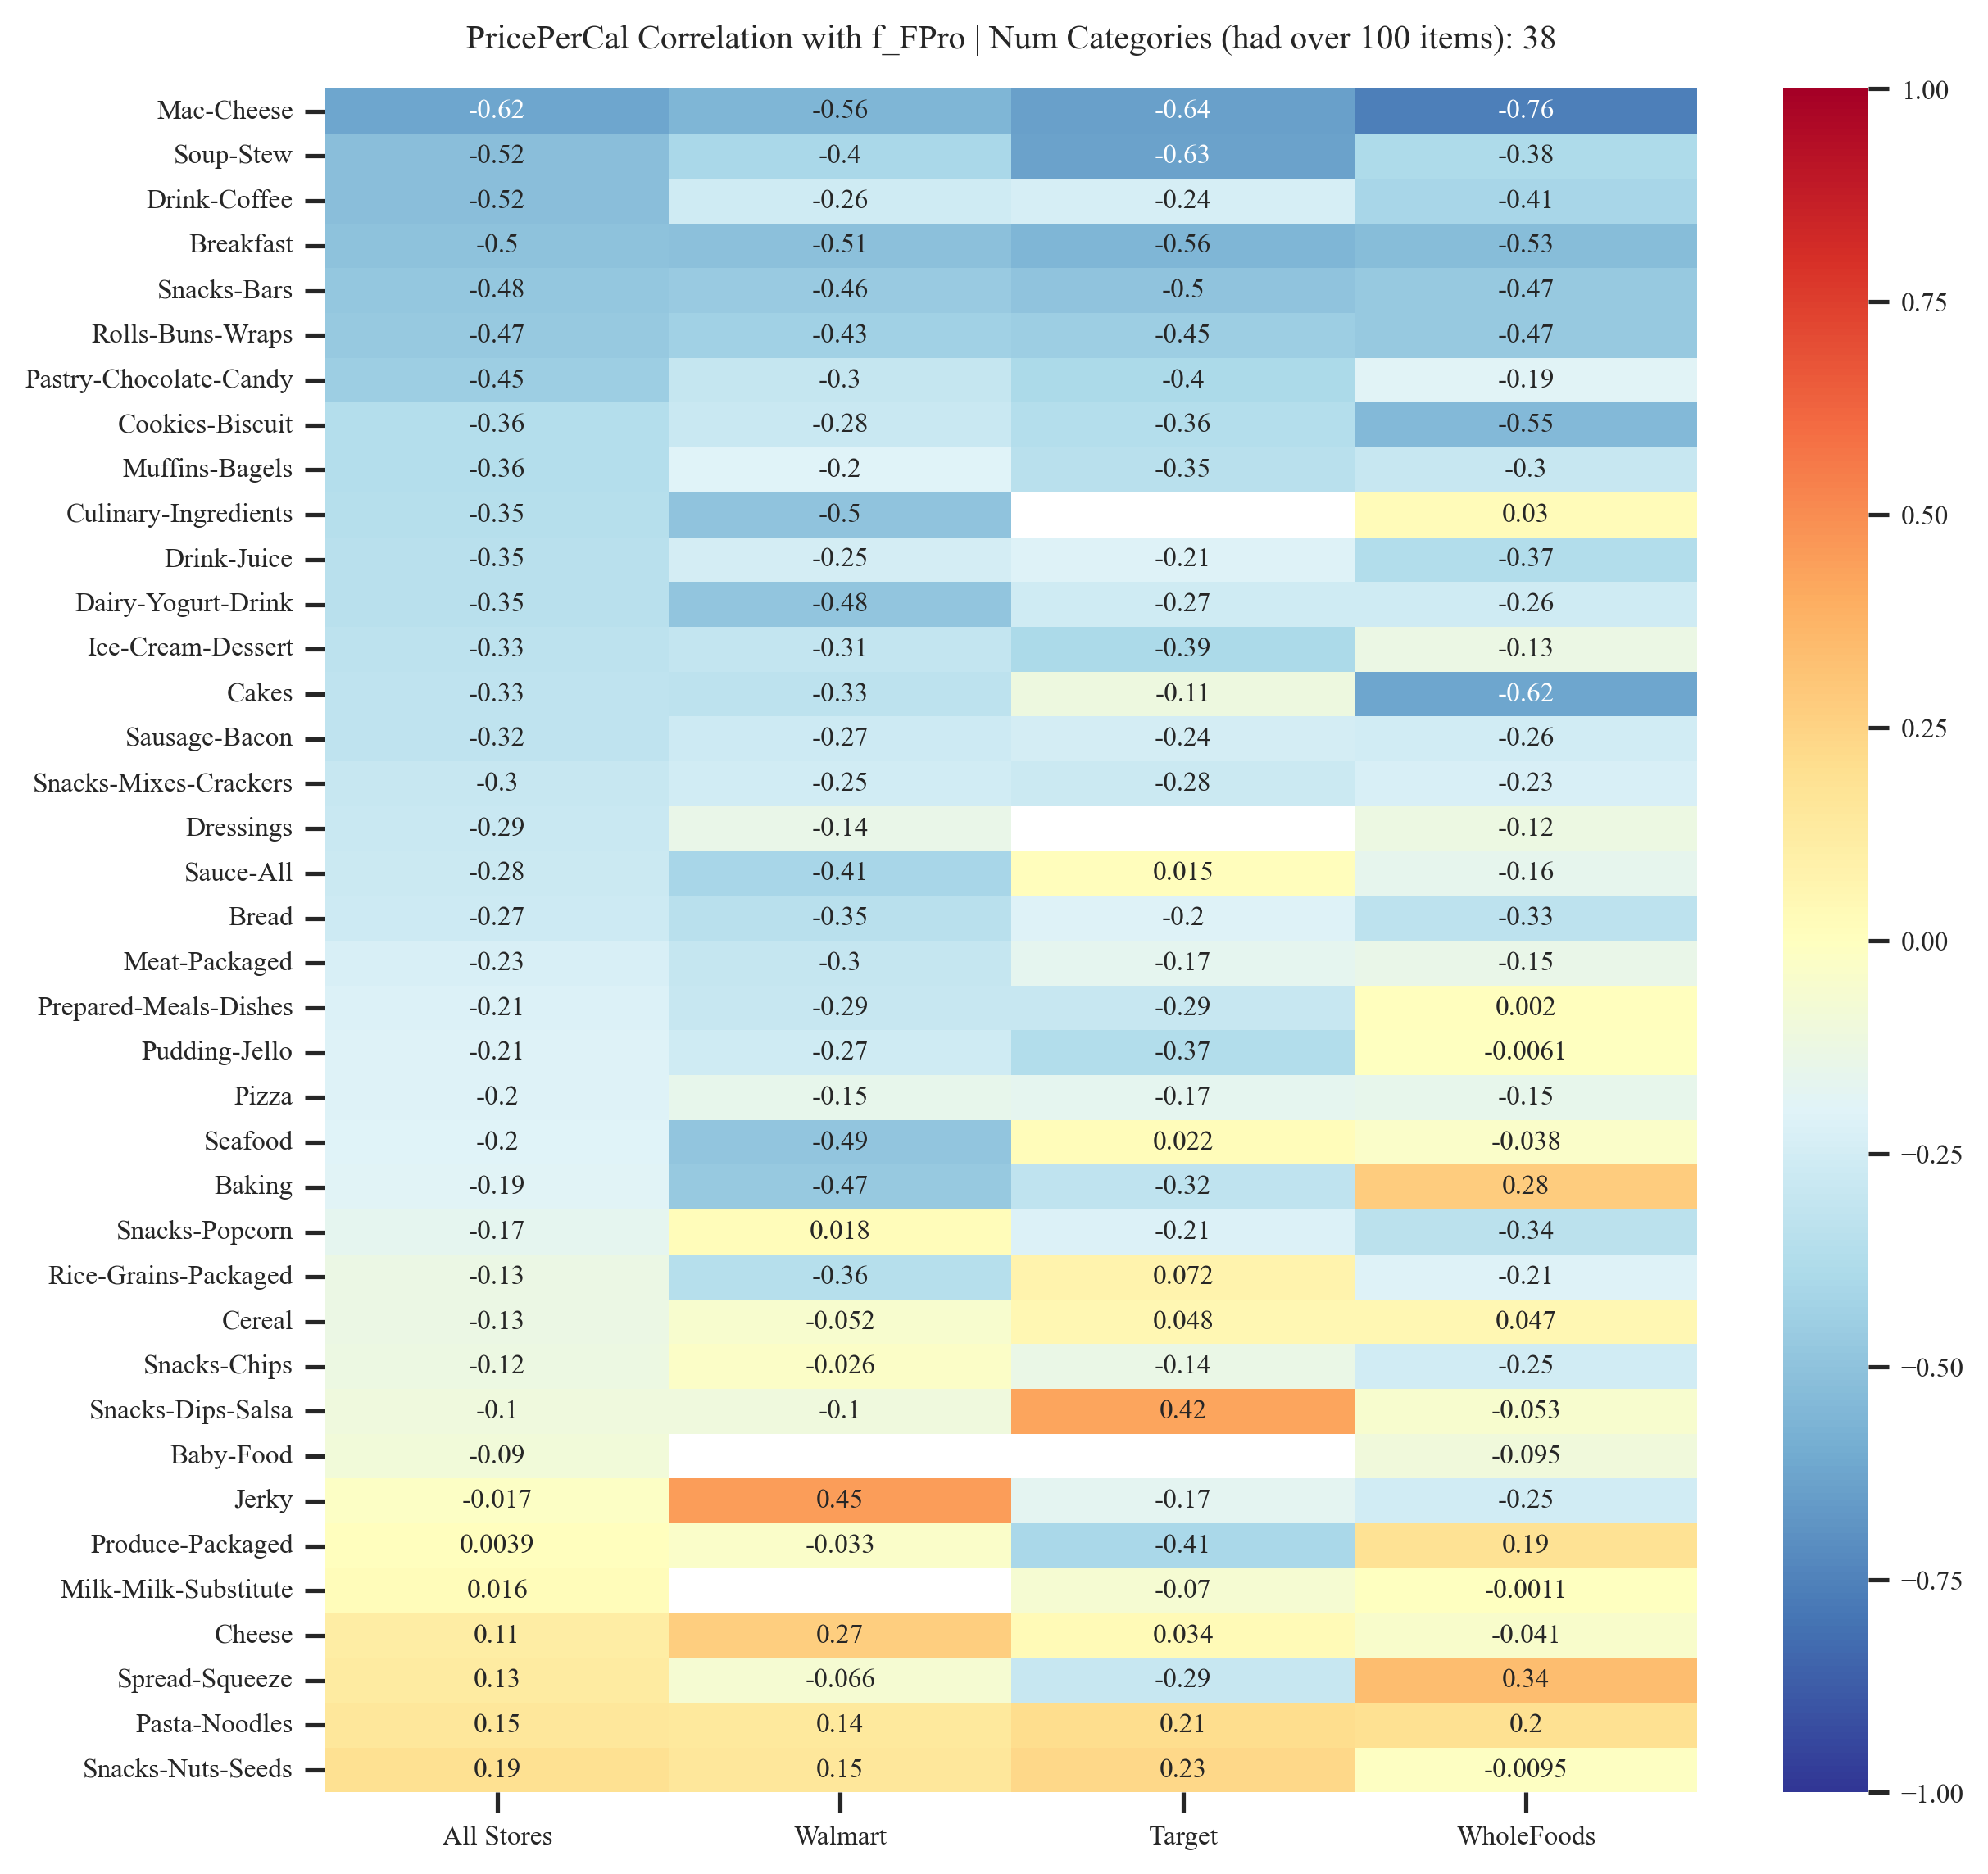

In [15]:
set_fonts()#font_size =12, font_scale

res = grocery_base.plot_correlation_matrix(
    cat_corr_df=cat_corr_df, 
    filter_min_num_items_in_category=100,
    cols_heatmap = ['All Stores'] + grocery_base.stores,
    title='PricePerCal Correlation with ' + col_FPro, 
    figsize=(9,9),
    font_size=8,
    add_count_items=False, vmin_vmax=(-1,1),
    export_path='output/figS7c.pdf'
)

### Filter Price per Cal 

In [16]:
gdb_price_df = gdb_conv_df[(~gdb_conv_df['price percal'].isnull()) & (~gdb_conv_df['price percal'].isin([np.inf, -np.inf]))]

limit_price_per_cal = [0.1, 0.15, 0.2][0] # these are products with issues
print('limit_price_per_cal:', limit_price_per_cal)
gdb_price_df = gdb_price_df[gdb_price_df['price percal'] <limit_price_per_cal].reset_index(drop=True)

limit_package_weight = [1000, 1500][0] # these are products with issues (too heavy like big pack of water rtc)
print('limit_package_weight:', limit_package_weight)
gdb_price_df = gdb_price_df[gdb_price_df['package_weight'] < limit_package_weight].reset_index(drop=True)

print('Num items with price: {} from {}'.format(len(gdb_price_df), len(gdb_conv_df)))

limit_price_per_cal: 0.1
limit_package_weight: 1000
Num items with price: 17887 from 24142


# Figure S7a

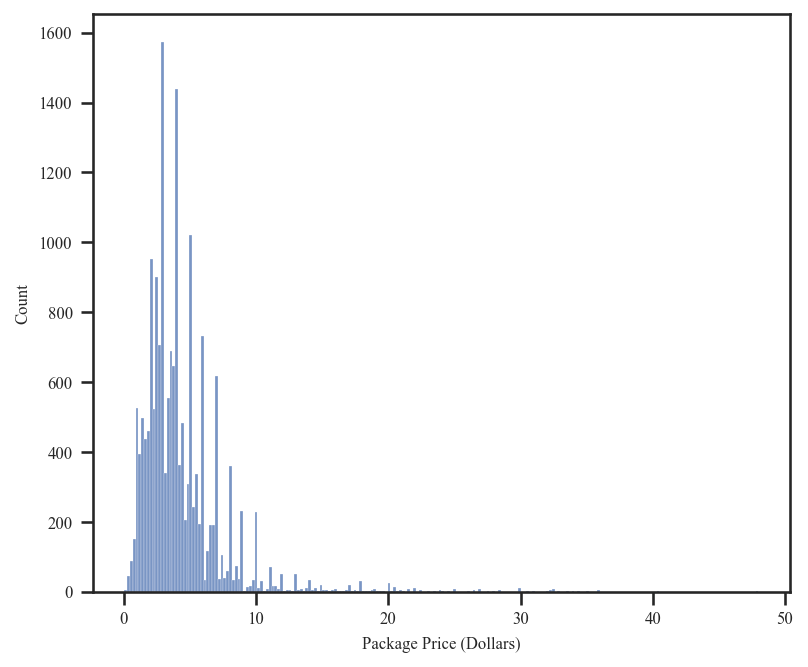

In [17]:
fig, axs = plt.subplots(1, figsize=(6, 5), dpi=150)
sns.set(style="ticks", font="Times New Roman", font_scale=1.0)
sns.set_style({'font.family': 'serif', 'font.serif': 'Times New Roman'})
g = sns.histplot(data=gdb_price_df, x='price', ax=axs)
g.set(xlabel='Package Price (Dollars)', ylabel='Count')
plt.savefig('output/figS7a.pdf')

# Figure S7b

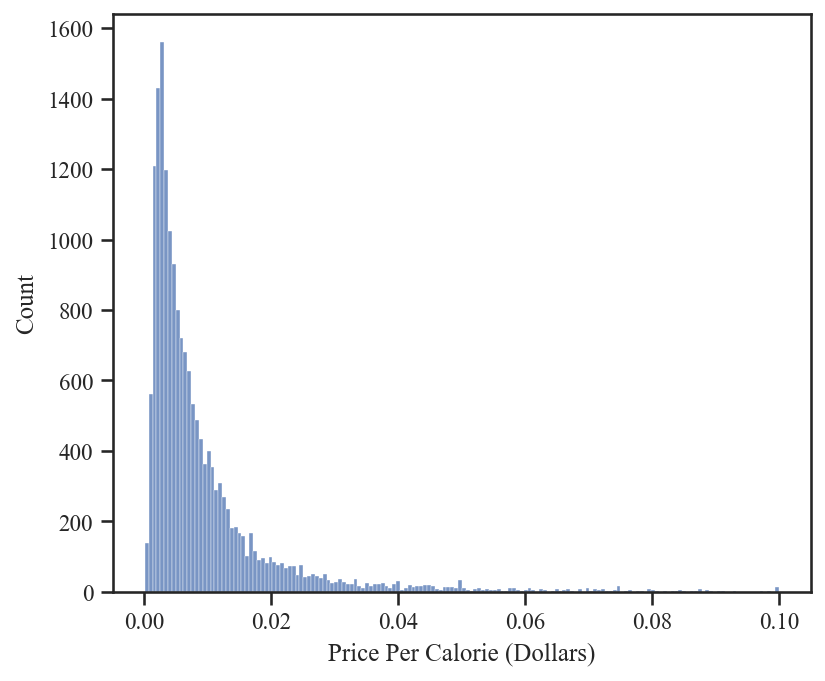

In [18]:
fig, axs = plt.subplots(1, figsize=(6, 5), dpi=150)
# soup dip , 'cakes', cereal

sns.set_style({'font.family': 'serif', 'font.serif': 'Times New Roman'})
sns.set(style="ticks", font="Times New Roman", font_scale=1.0)
g = sns.histplot(data=gdb_price_df, x='price percal', ax=axs)
g.set(xlabel='Price Per Calorie (Dollars)', ylabel='Count')
plt.savefig('output/figS7b.pdf')

### Fit PricePerCal ~ FPro

standardized: 

$$$$$$$$$$$$$$$[ALL] price ~ FPro --> coef: -0.8072 RLM: -0.9386x + -5.4337 (pval: 0.0) | count: 19254


C:\Users\sobek\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



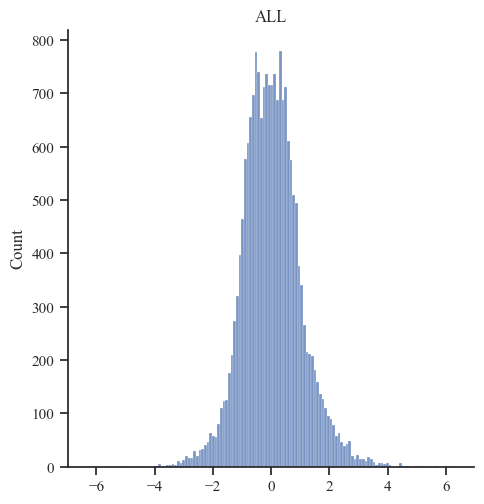


$$$$$$$$$$$$$$$[baby-food] price ~ FPro --> coef: -0.1489 RLM: -0.1418x + -3.7860 (pval: 0.3682164468441961) | count: 115


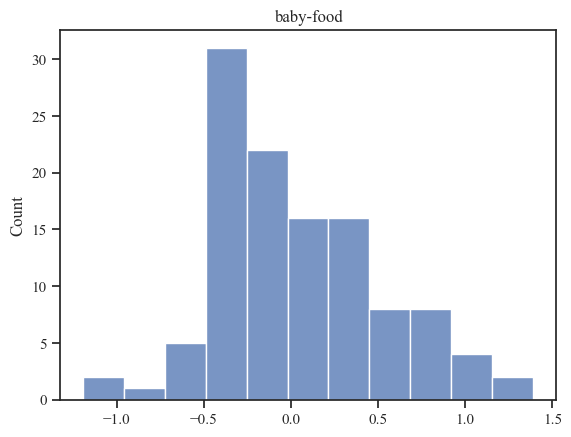


$$$$$$$$$$$$$$$[baking] price ~ FPro --> coef: 0.1956 RLM: 0.1014x + -5.9606 (pval: 0.45413661416772766) | count: 324


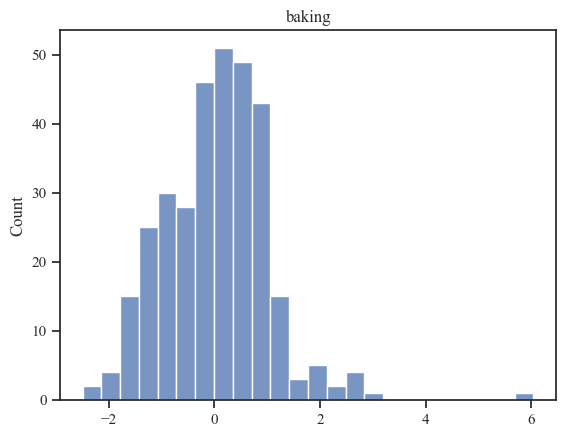


$$$$$$$$$$$$$$$[bread] price ~ FPro --> coef: -1.7649 RLM: -2.0023x + -5.9189 (pval: 1.415377074406658e-11) | count: 538


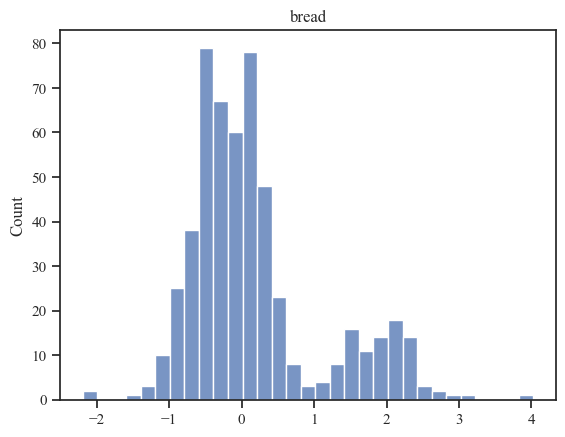


$$$$$$$$$$$$$$$[breakfast] price ~ FPro --> coef: -2.5189 RLM: -2.8592x + -5.8965 (pval: 2.780330359784091e-23) | count: 246


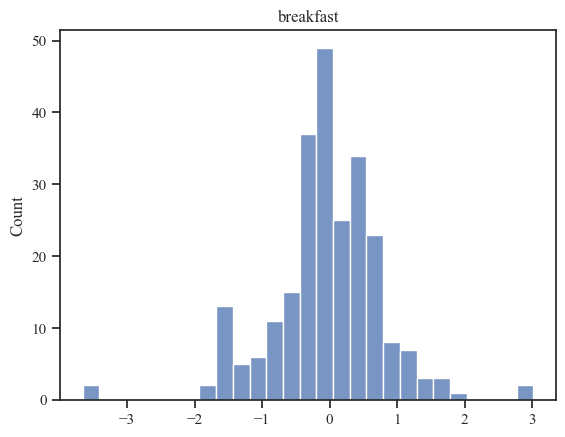


$$$$$$$$$$$$$$$[cakes] price ~ FPro --> coef: -4.8627 RLM: -5.2420x + -5.9964 (pval: 2.387222282353427e-28) | count: 322


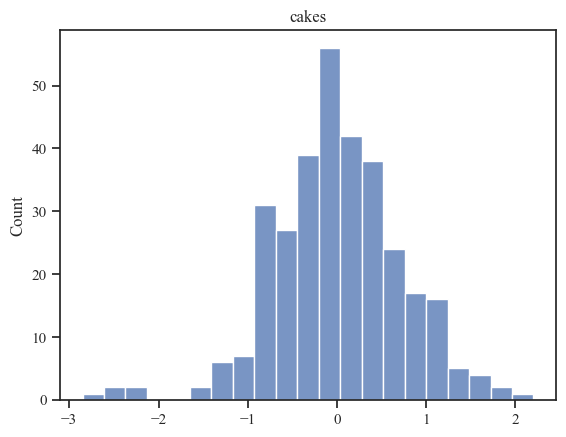


$$$$$$$$$$$$$$$[cereal] price ~ FPro --> coef: -0.1298 RLM: -0.1164x + -5.8495 (pval: 0.19813791204169484) | count: 659


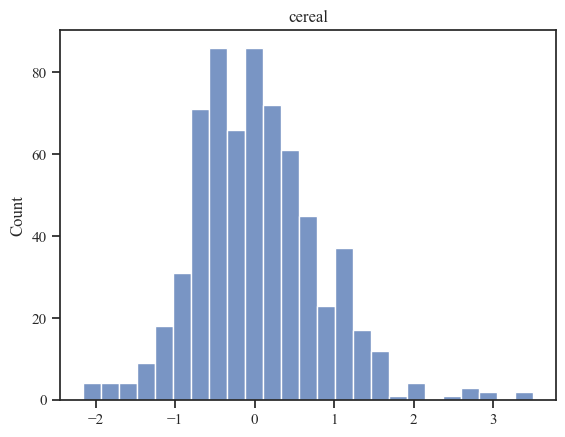


$$$$$$$$$$$$$$$[cheese] price ~ FPro --> coef: 0.2184 RLM: 0.3706x + -5.0435 (pval: 0.016703497050124527) | count: 783


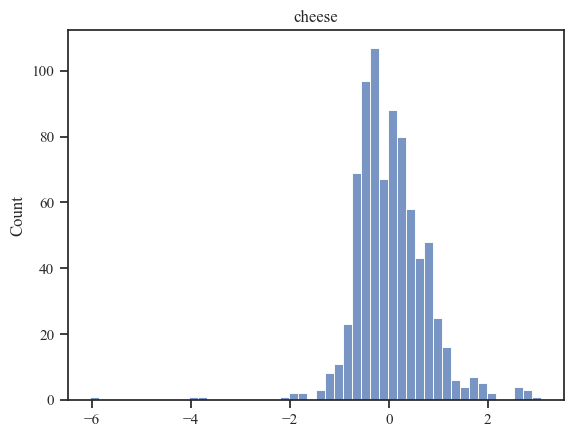


$$$$$$$$$$$$$$$[cookies-biscuit] price ~ FPro --> coef: -4.4861 RLM: -4.1243x + -6.0111 (pval: 3.5363641593840554e-72) | count: 964


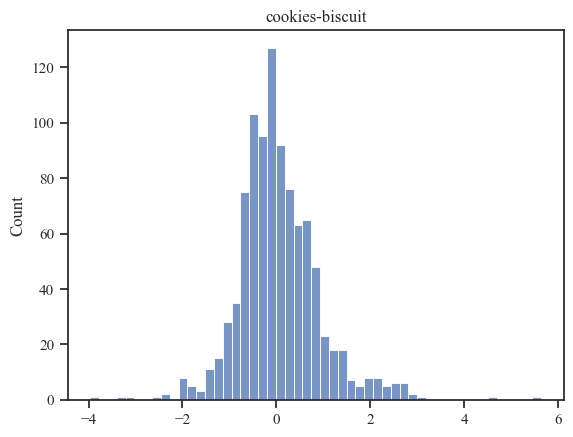


$$$$$$$$$$$$$$$[culinary-ingredients] price ~ FPro --> coef: -0.4685 RLM: -0.6910x + -6.3528 (pval: 0.01802617278383038) | count: 141


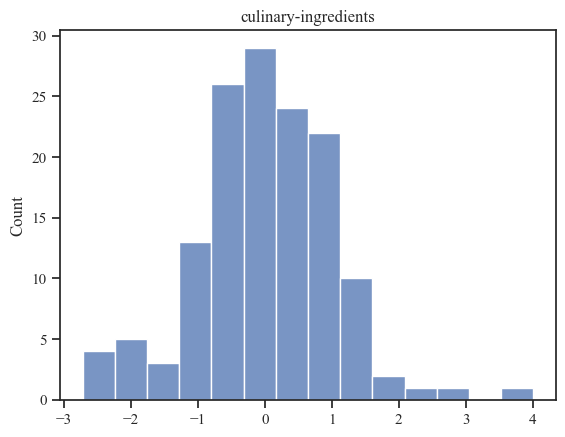


$$$$$$$$$$$$$$$[dairy-yogurt-drink] price ~ FPro --> coef: -0.3426 RLM: -0.3728x + -4.8162 (pval: 6.91944416123107e-10) | count: 682


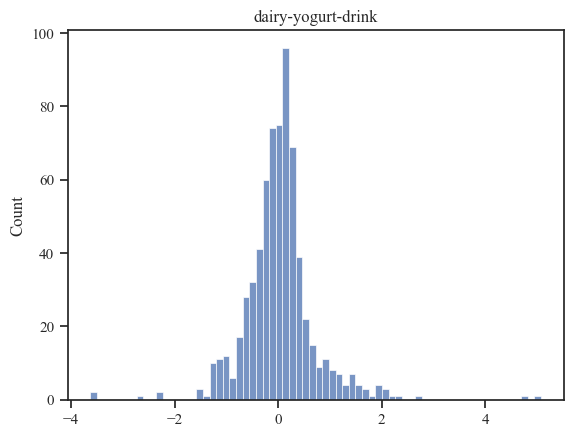


$$$$$$$$$$$$$$$[dressings] price ~ FPro --> coef: -0.5969 RLM: -0.7045x + -5.5474 (pval: 0.057219175821714575) | count: 435


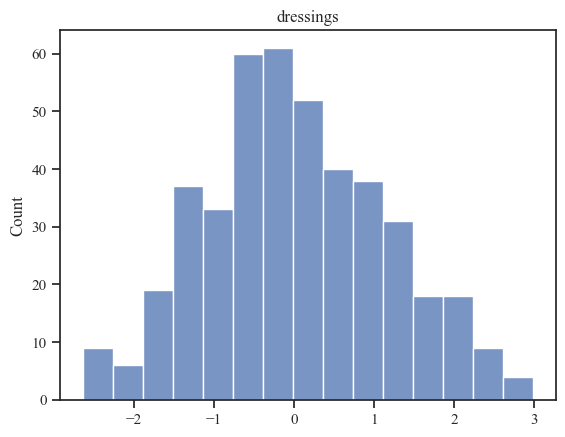


$$$$$$$$$$$$$$$[drink-coffee] price ~ FPro --> coef: -2.3634 RLM: -2.3657x + -5.3187 (pval: 1.3355982349819535e-13) | count: 155


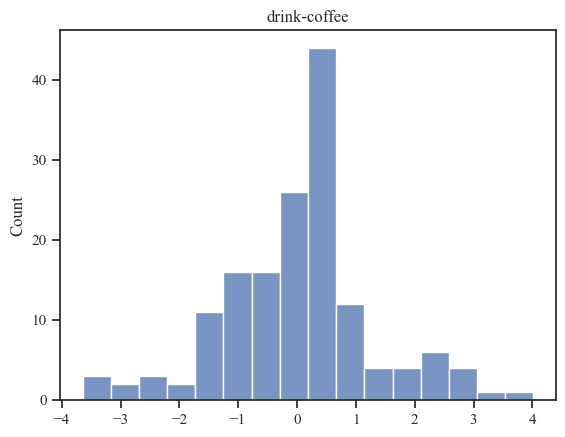


$$$$$$$$$$$$$$$[drink-juice] price ~ FPro --> coef: -1.2614 RLM: -1.4680x + -5.3740 (pval: 4.630127017202268e-14) | count: 295


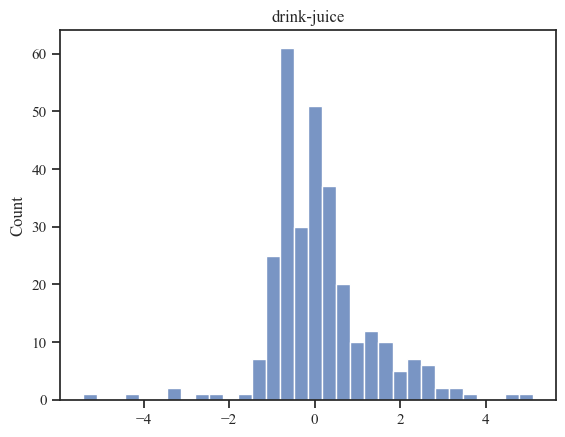


$$$$$$$$$$$$$$$[drink-shakes-other] price ~ FPro --> coef: -2.2586 RLM: -2.3361x + -5.2763 (pval: 2.8912934021263736e-16) | count: 227


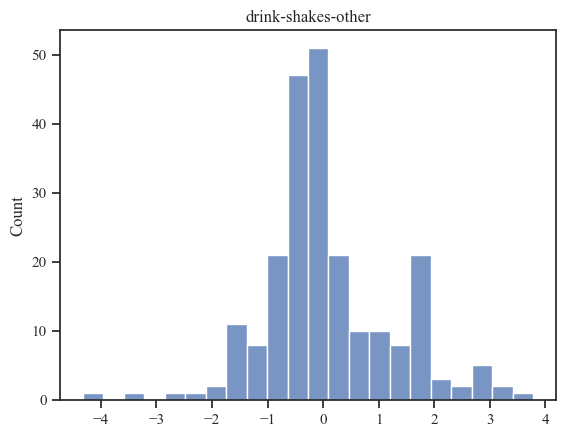


$$$$$$$$$$$$$$$[drink-soft-energy-mixes] price ~ FPro --> coef: -1.2395 RLM: -1.3160x + -4.8912 (pval: 0.005716051741203092) | count: 88


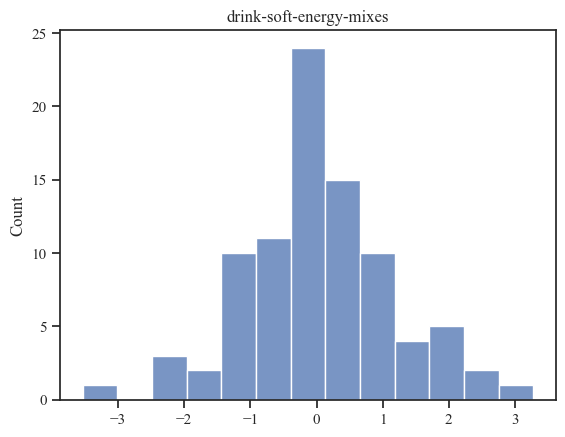


$$$$$$$$$$$$$$$[drink-tea] price ~ FPro --> coef: -4.4250 RLM: -4.3508x + -5.9413 (pval: 1.1370230151503025e-20) | count: 45


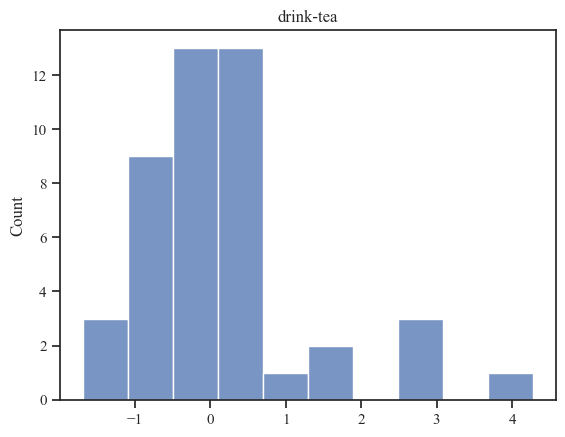


$$$$$$$$$$$$$$$[ice-cream-dessert] price ~ FPro --> coef: -2.2048 RLM: -2.5365x + -5.9451 (pval: 3.019827329799349e-29) | count: 645


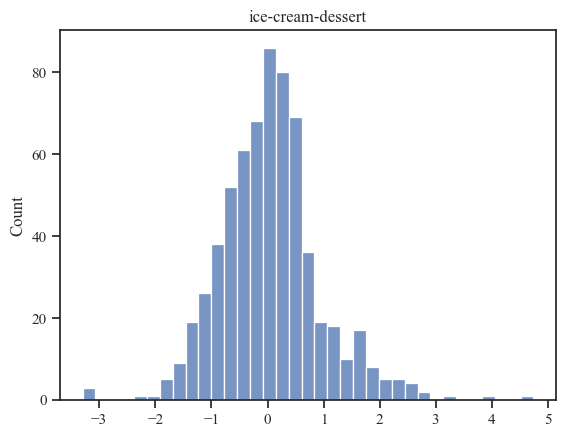


$$$$$$$$$$$$$$$[jerky] price ~ FPro --> coef: 2.1603 RLM: 1.4900x + -3.1708 (pval: 0.09006580948792235) | count: 208


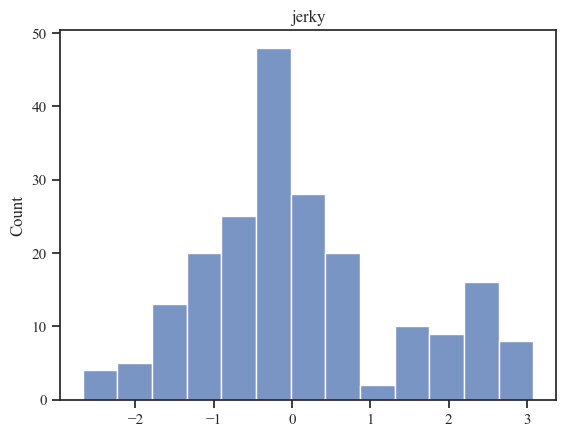


$$$$$$$$$$$$$$$[mac-cheese] price ~ FPro --> coef: -3.0935 RLM: -3.2669x + -5.8248 (pval: 5.1807274642531434e-24) | count: 184


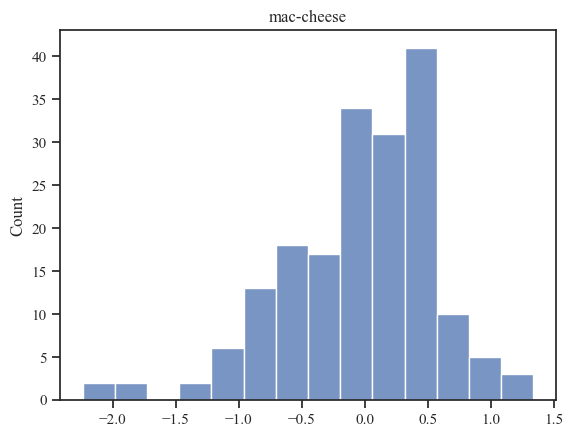


$$$$$$$$$$$$$$$[meat-packaged] price ~ FPro --> coef: -0.3430 RLM: -0.3672x + -4.6746 (pval: 0.0001496339789391266) | count: 744


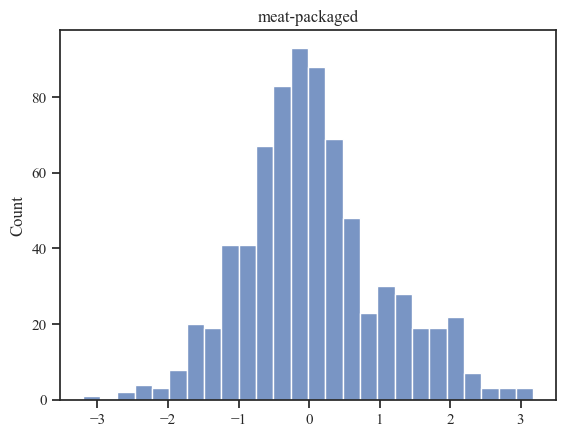


$$$$$$$$$$$$$$$[milk-milk-substitute] price ~ FPro --> coef: 0.1812 RLM: 0.1635x + -4.6070 (pval: 0.007814874990921887) | count: 240


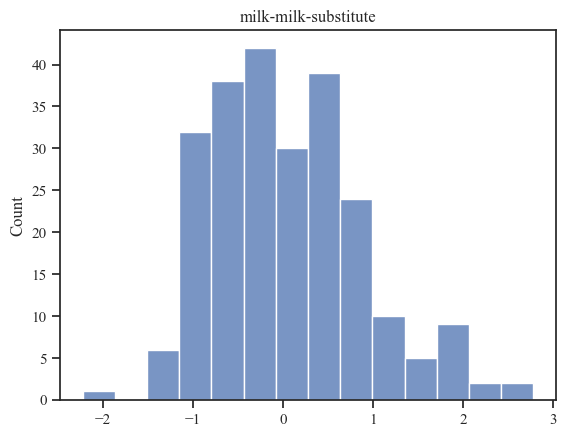


$$$$$$$$$$$$$$$[muffins-bagels] price ~ FPro --> coef: -2.9268 RLM: -3.2548x + -5.8497 (pval: 1.0053026639092049e-12) | count: 199


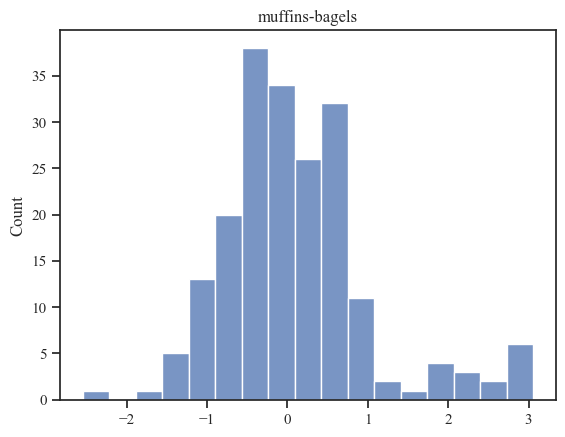


$$$$$$$$$$$$$$$[pasta-noodles] price ~ FPro --> coef: 0.7651 RLM: 0.5796x + -5.5425 (pval: 0.0006928440204179565) | count: 177


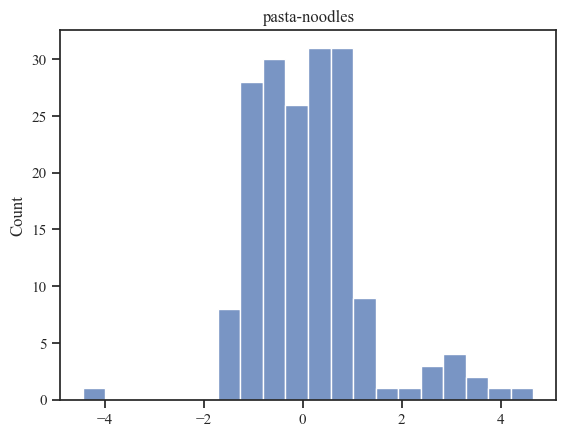


$$$$$$$$$$$$$$$[pastry-chocolate-candy] price ~ FPro --> coef: -1.4571 RLM: -1.5161x + -5.8078 (pval: 4.92565647093133e-56) | count: 1308


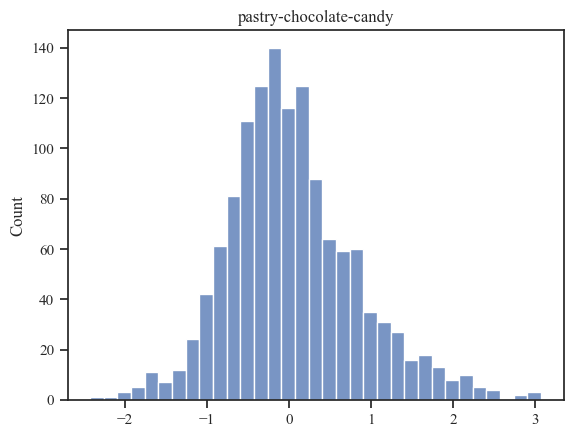


$$$$$$$$$$$$$$$[pizza] price ~ FPro --> coef: -1.1721 RLM: -1.3846x + -5.5092 (pval: 4.0056390005246194e-05) | count: 337


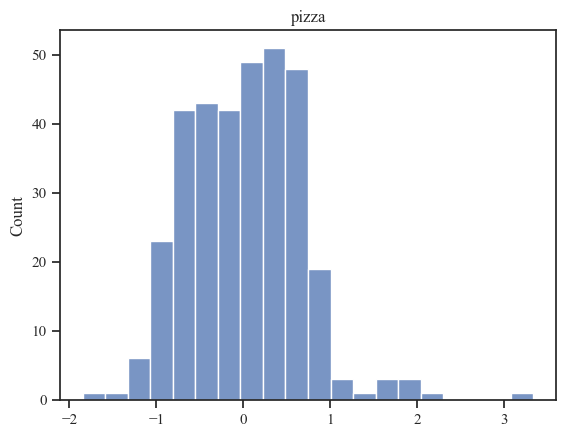


$$$$$$$$$$$$$$$[prepared-meals-dishes] price ~ FPro --> coef: -0.0925 RLM: -0.4260x + -4.9747 (pval: 3.212103475619052e-05) | count: 1627


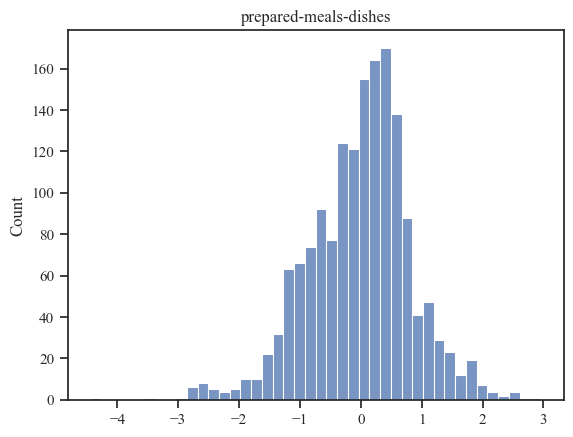


$$$$$$$$$$$$$$$[produce-packaged] price ~ FPro --> coef: 0.1477 RLM: 0.1608x + -4.5459 (pval: 0.15833702981141295) | count: 948


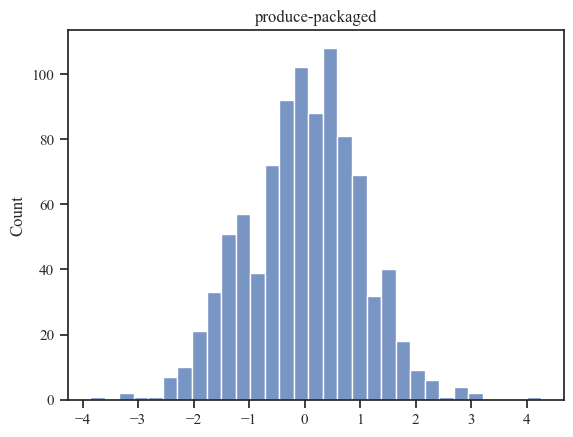


$$$$$$$$$$$$$$$[pudding-jello] price ~ FPro --> coef: -2.9739 RLM: -2.6609x + -5.7403 (pval: 5.947349213263269e-09) | count: 134


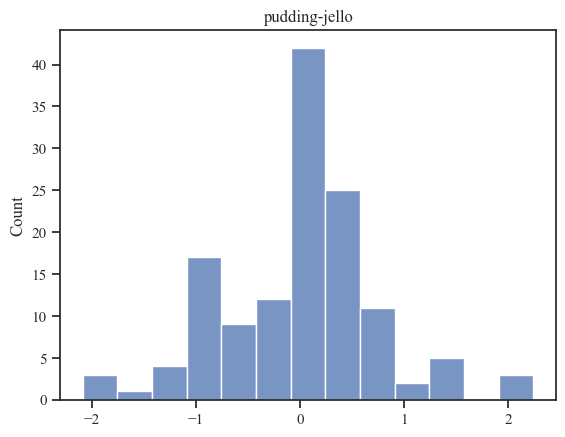


$$$$$$$$$$$$$$$[rice-grains-packaged] price ~ FPro --> coef: -0.1038 RLM: -0.1399x + -5.1656 (pval: 0.2976881546651814) | count: 114


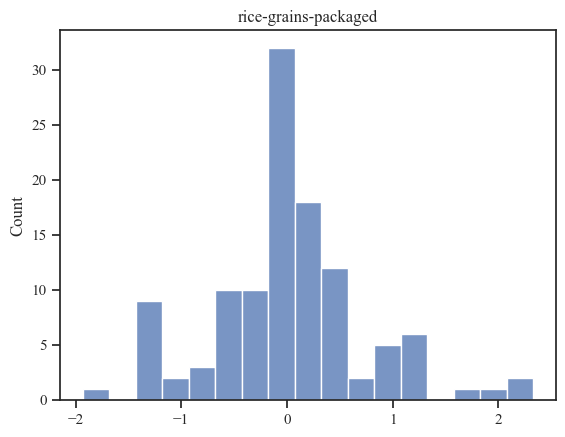


$$$$$$$$$$$$$$$[rolls-buns-wraps] price ~ FPro --> coef: -1.4685 RLM: -1.7792x + -5.7358 (pval: 1.566213248488266e-29) | count: 512


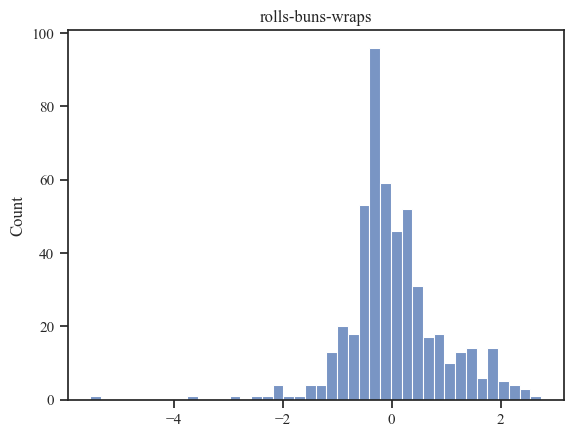


$$$$$$$$$$$$$$$[salad] price ~ FPro --> coef: -1.8468 RLM: -1.7836x + -5.2347 (pval: 7.813123237987465e-16) | count: 88


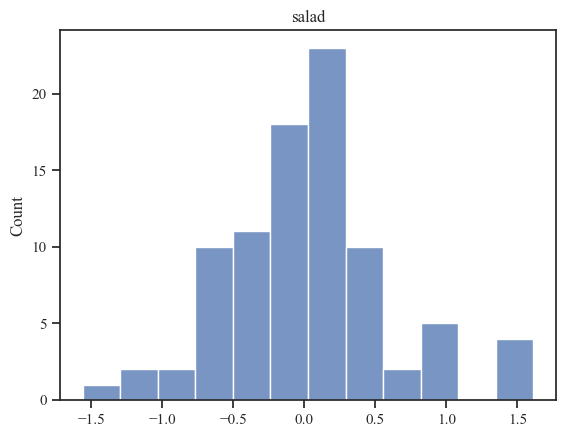


$$$$$$$$$$$$$$$[sauce-all] price ~ FPro --> coef: -1.2857 RLM: -1.2049x + -5.1887 (pval: 1.8540397676775352e-07) | count: 513


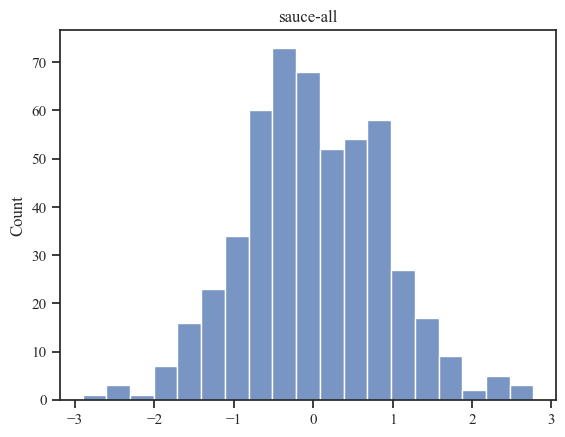


$$$$$$$$$$$$$$$[sausage-bacon] price ~ FPro --> coef: -1.4015 RLM: -1.4890x + -5.5894 (pval: 1.3712911589505581e-11) | count: 392


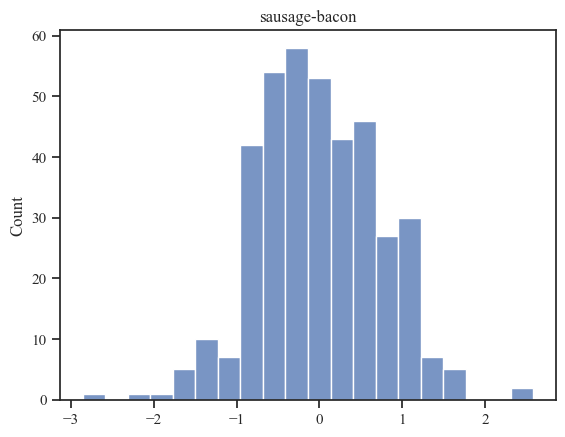


$$$$$$$$$$$$$$$[seafood] price ~ FPro --> coef: -0.4828 RLM: -0.4003x + -4.4905 (pval: 1.6524999199321356e-05) | count: 328


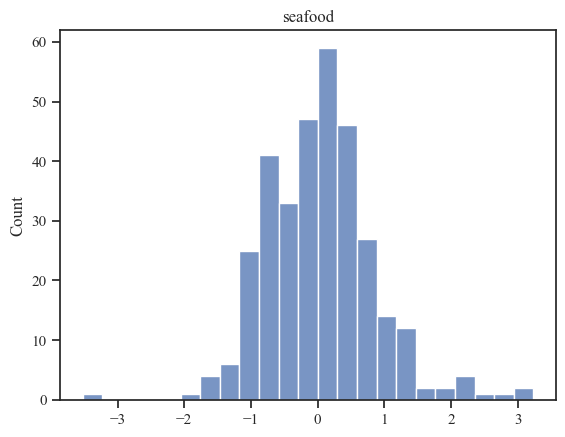


$$$$$$$$$$$$$$$[snacks-bars] price ~ FPro --> coef: -1.3102 RLM: -1.3065x + -5.2663 (pval: 3.0968460839461573e-62) | count: 1125


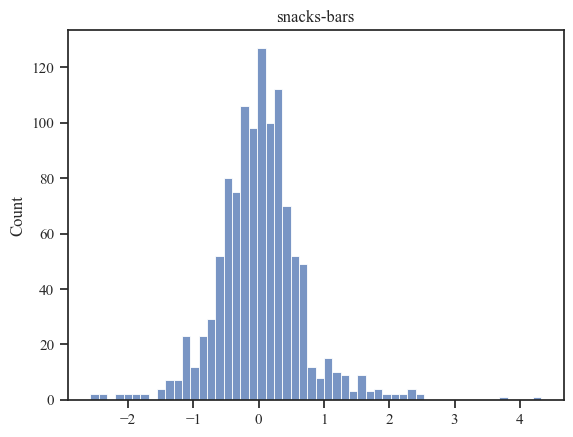


$$$$$$$$$$$$$$$[snacks-chips] price ~ FPro --> coef: -2.3117 RLM: -2.3283x + -5.9506 (pval: 2.9587840491418204e-40) | count: 864


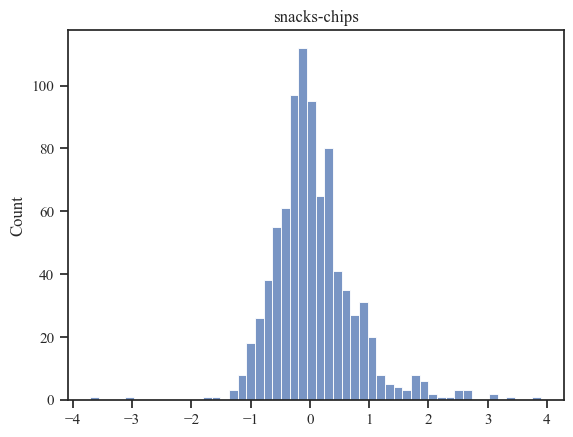


$$$$$$$$$$$$$$$[snacks-dips-salsa] price ~ FPro --> coef: -1.2071 RLM: -1.1421x + -4.8865 (pval: 0.011385658134842542) | count: 282


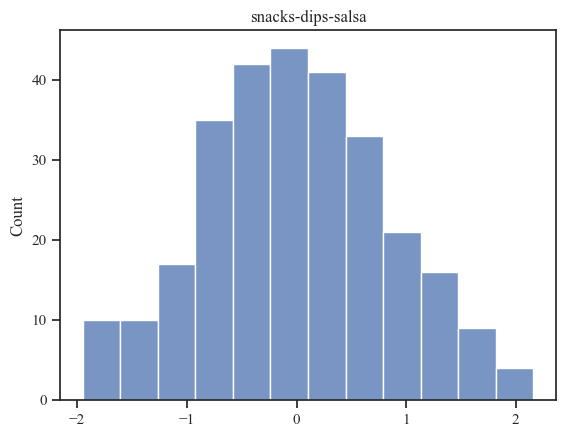


$$$$$$$$$$$$$$$[snacks-mixes-crackers] price ~ FPro --> coef: -2.1386 RLM: -2.3132x + -5.9063 (pval: 1.0213572905873149e-41) | count: 938


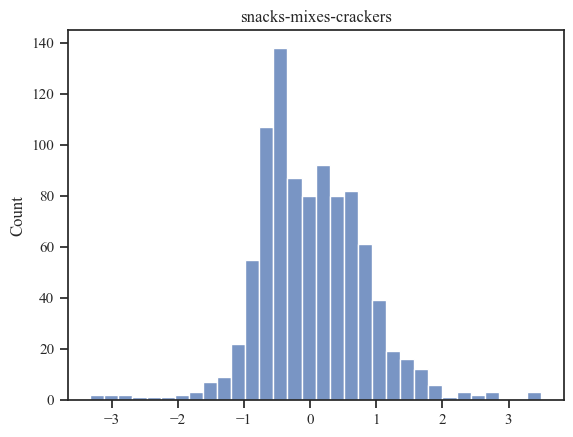


$$$$$$$$$$$$$$$[snacks-nuts-seeds] price ~ FPro --> coef: 0.3795 RLM: 0.3243x + -5.3680 (pval: 0.002643851432326618) | count: 296


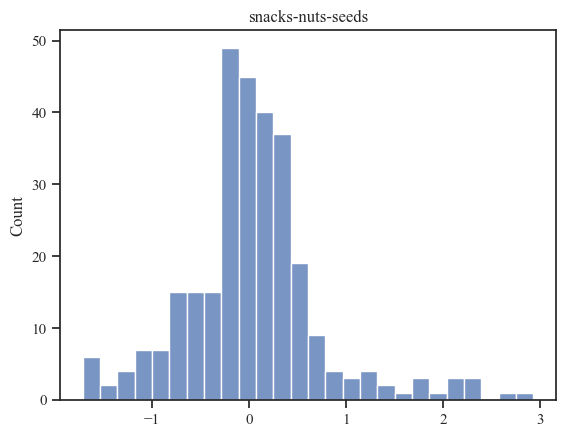


$$$$$$$$$$$$$$$[snacks-popcorn] price ~ FPro --> coef: 0.4650 RLM: 0.3703x + -5.6264 (pval: 0.378911557432985) | count: 184


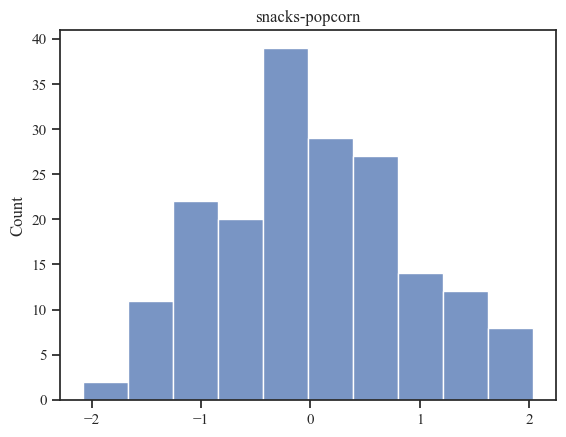


$$$$$$$$$$$$$$$[soup-stew] price ~ FPro --> coef: -2.6104 RLM: -2.9783x + -5.2932 (pval: 5.940769552662145e-36) | count: 505


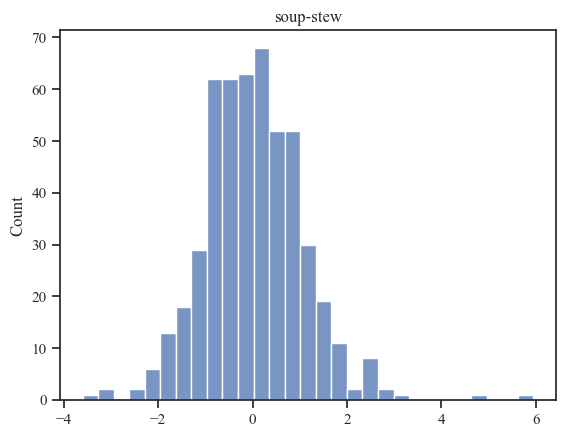


$$$$$$$$$$$$$$$[spices-seasoning] price ~ FPro --> coef: -0.6391 RLM: -0.5304x + -4.3631 (pval: 2.776499254803016e-06) | count: 107


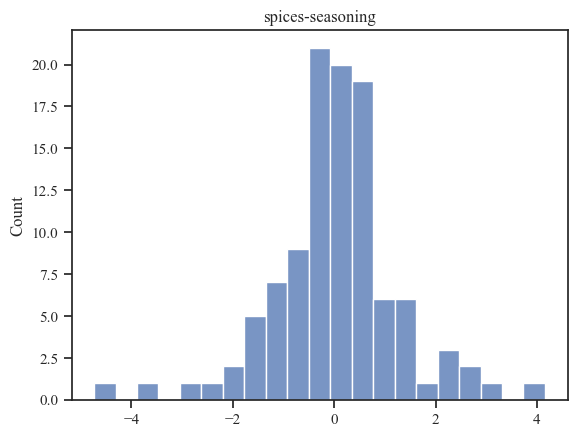


$$$$$$$$$$$$$$$[spread-squeeze] price ~ FPro --> coef: 0.0459 RLM: 0.0452x + -5.3852 (pval: 0.686401237650041) | count: 236


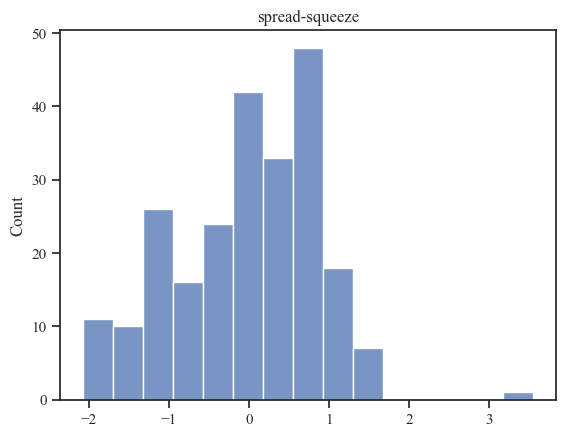

In [19]:
fpro_min = 0.0
reg_results = []
col_categories = 'harmonized single category'
esitmate_perc_change_apply_log = False

col_price = 'price percal'
standardized = ['', ' Standardized'][0]
print('standardized:', standardized)

for cat in ['ALL'] + list(gdb_conv_df[col_categories].unique()):
    
#     if cat != 'milk-milk-substitute':
#         continue
    
    if cat == 'ALL':
        cat_price_df = gdb_conv_df[[col_categories, 'f_FPro', col_price, 'store']]
    else:
        cat_price_df = gdb_conv_df[gdb_conv_df[col_categories] == cat][[col_categories, 'f_FPro', col_price, 'store']]
        
    cat_price_df = cat_price_df[
        (~cat_price_df[col_price].isnull()) 
        & (cat_price_df['f_FPro'] >= fpro_min)
    ].reset_index(drop=True)
    
    cat_price_df['f_FPro Standardized'] = cat_price_df['f_FPro'].apply(
        lambda fpro: grocery_base.normalizeBetweenTwoRanges(
            val=fpro, 
            minVal=cat_price_df['f_FPro'].min(), 
            maxVal=cat_price_df['f_FPro'].max(), 
            newMin=0,
            newMax=1
        )
    )
        
    cat_price_df[col_price + ' Standardized'] = cat_price_df[col_price].apply(
        lambda fpro: grocery_base.normalizeBetweenTwoRanges(
            val=fpro, 
            minVal=cat_price_df[col_price].min(), 
            maxVal=cat_price_df[col_price].max(), 
            newMin=0,
            newMax=1
        )
    )
    
    try:
        x_vals = cat_price_df['f_FPro' + standardized]
        
        x_vals = x_vals.apply(np.log)
        
        # to estimate % change
        if esitmate_perc_change_apply_log:
            x_vals = (x_vals * 100).apply(np.log)

        y = cat_price_df[col_price + standardized]
        
        y = y.apply(np.log)

        coef_np_polyfit = np.polyfit(x_vals, y, 1)

        X = np.c_[np.ones(len(x_vals)), x_vals]

        rlm_model = sm.RLM(y, X, sm.robust.norms.HuberT())
        
        rlm_results = rlm_model.fit()
        
        cat_price_df['rlm weights'] = rlm_results.weights
        
        reg_results.append({
            'cat': cat,
            'count items': len(cat_price_df) ,
            'OLS coef': coef_np_polyfit[0],
            'RLM coef': rlm_results.params[1],
            'RLM const': rlm_results.params[0],
            'RLM pvalue': rlm_results.pvalues[1]
        })
        
        if True:
            print('\n$$$$$$$$$$$$$$$[{}] price ~ FPro --> coef: {:.4f} RLM: {:.4f}x + {:.4f} (pval: {}) | count: {}'.format(
                cat, coef_np_polyfit[0], 
                rlm_results.params[1],
                rlm_results.params[0],
                rlm_results.pvalues[1],
                len(cat_price_df)
            ))

            
        if cat == 'ALL':
            g = sns.displot(data=rlm_results.resid)
        else:
            g = sns.histplot(rlm_results.resid)
            
        g.set(title=cat)
        plt.show()

        pass
    #         print(rlm_results.params)
    #         print(rlm_results.bse)

    #         print(
    #             rlm_results.summary(
    #                 yname="y", xname=["var_%d" % i for i in range(len(rlm_results.params))]
    #             )
    #         )

    except Exception as ex:
        print('\n-->> !!!!!!!!!!!!!!!!!!![Error] Category:', cat, ex)
        pass    
    
#     break
    
    pass
# [cookies-biscuit] coef: -0.0817 RLM: -0.0248 | count: 963

reg_results = pd.DataFrame(reg_results).sort_values('RLM coef')

In [20]:
def pval_star(pval):

    if pval < 0.001:
        return '***'

    elif 0.001 <= pval < 0.01:
        return '**'

    elif 0.01 <= pval < 0.05:
        return '*'

    elif 0.05 <= pval < 0.1:
        return ''#'.'
    else:
        return ''
            
    return row
    pass

reg_results['RLM coef pval'] = (
    reg_results['RLM coef'].round(4).astype(str) + '' +
    reg_results['RLM pvalue'].apply(lambda pval: pval_star(pval))
)

reg_results['RLM pval stars'] = (
    reg_results['RLM pvalue'].apply(lambda pval: pval_star(pval))
)

print('esitmate_perc_change_apply_log:', esitmate_perc_change_apply_log)

if esitmate_perc_change_apply_log:
    reg_results['PricePerCal Change % for 0.1 FPro'] = reg_results['RLM coef'] * 100 * 10

reg_results.head()

esitmate_perc_change_apply_log: False


cat  count items  OLS coef  RLM coef  RLM const    RLM pvalue  \
5   cakes            322         -4.862726 -5.241985 -5.996365   2.387222e-28   
16  drink-tea        45          -4.425029 -4.350784 -5.941285   1.137023e-20   
8   cookies-biscuit  964         -4.486115 -4.124257 -6.011060   3.536364e-72   
19  mac-cheese       184         -3.093467 -3.266915 -5.824761   5.180727e-24   
22  muffins-bagels   199         -2.926814 -3.254778 -5.849661   1.005303e-12   

   RLM coef pval RLM pval stars  
5   -5.242***     ***            
16  -4.3508***    ***            
8   -4.1243***    ***            
19  -3.2669***    ***            
22  -3.2548***    ***

# Figure S8

esitmate_perc_change_apply_log: False


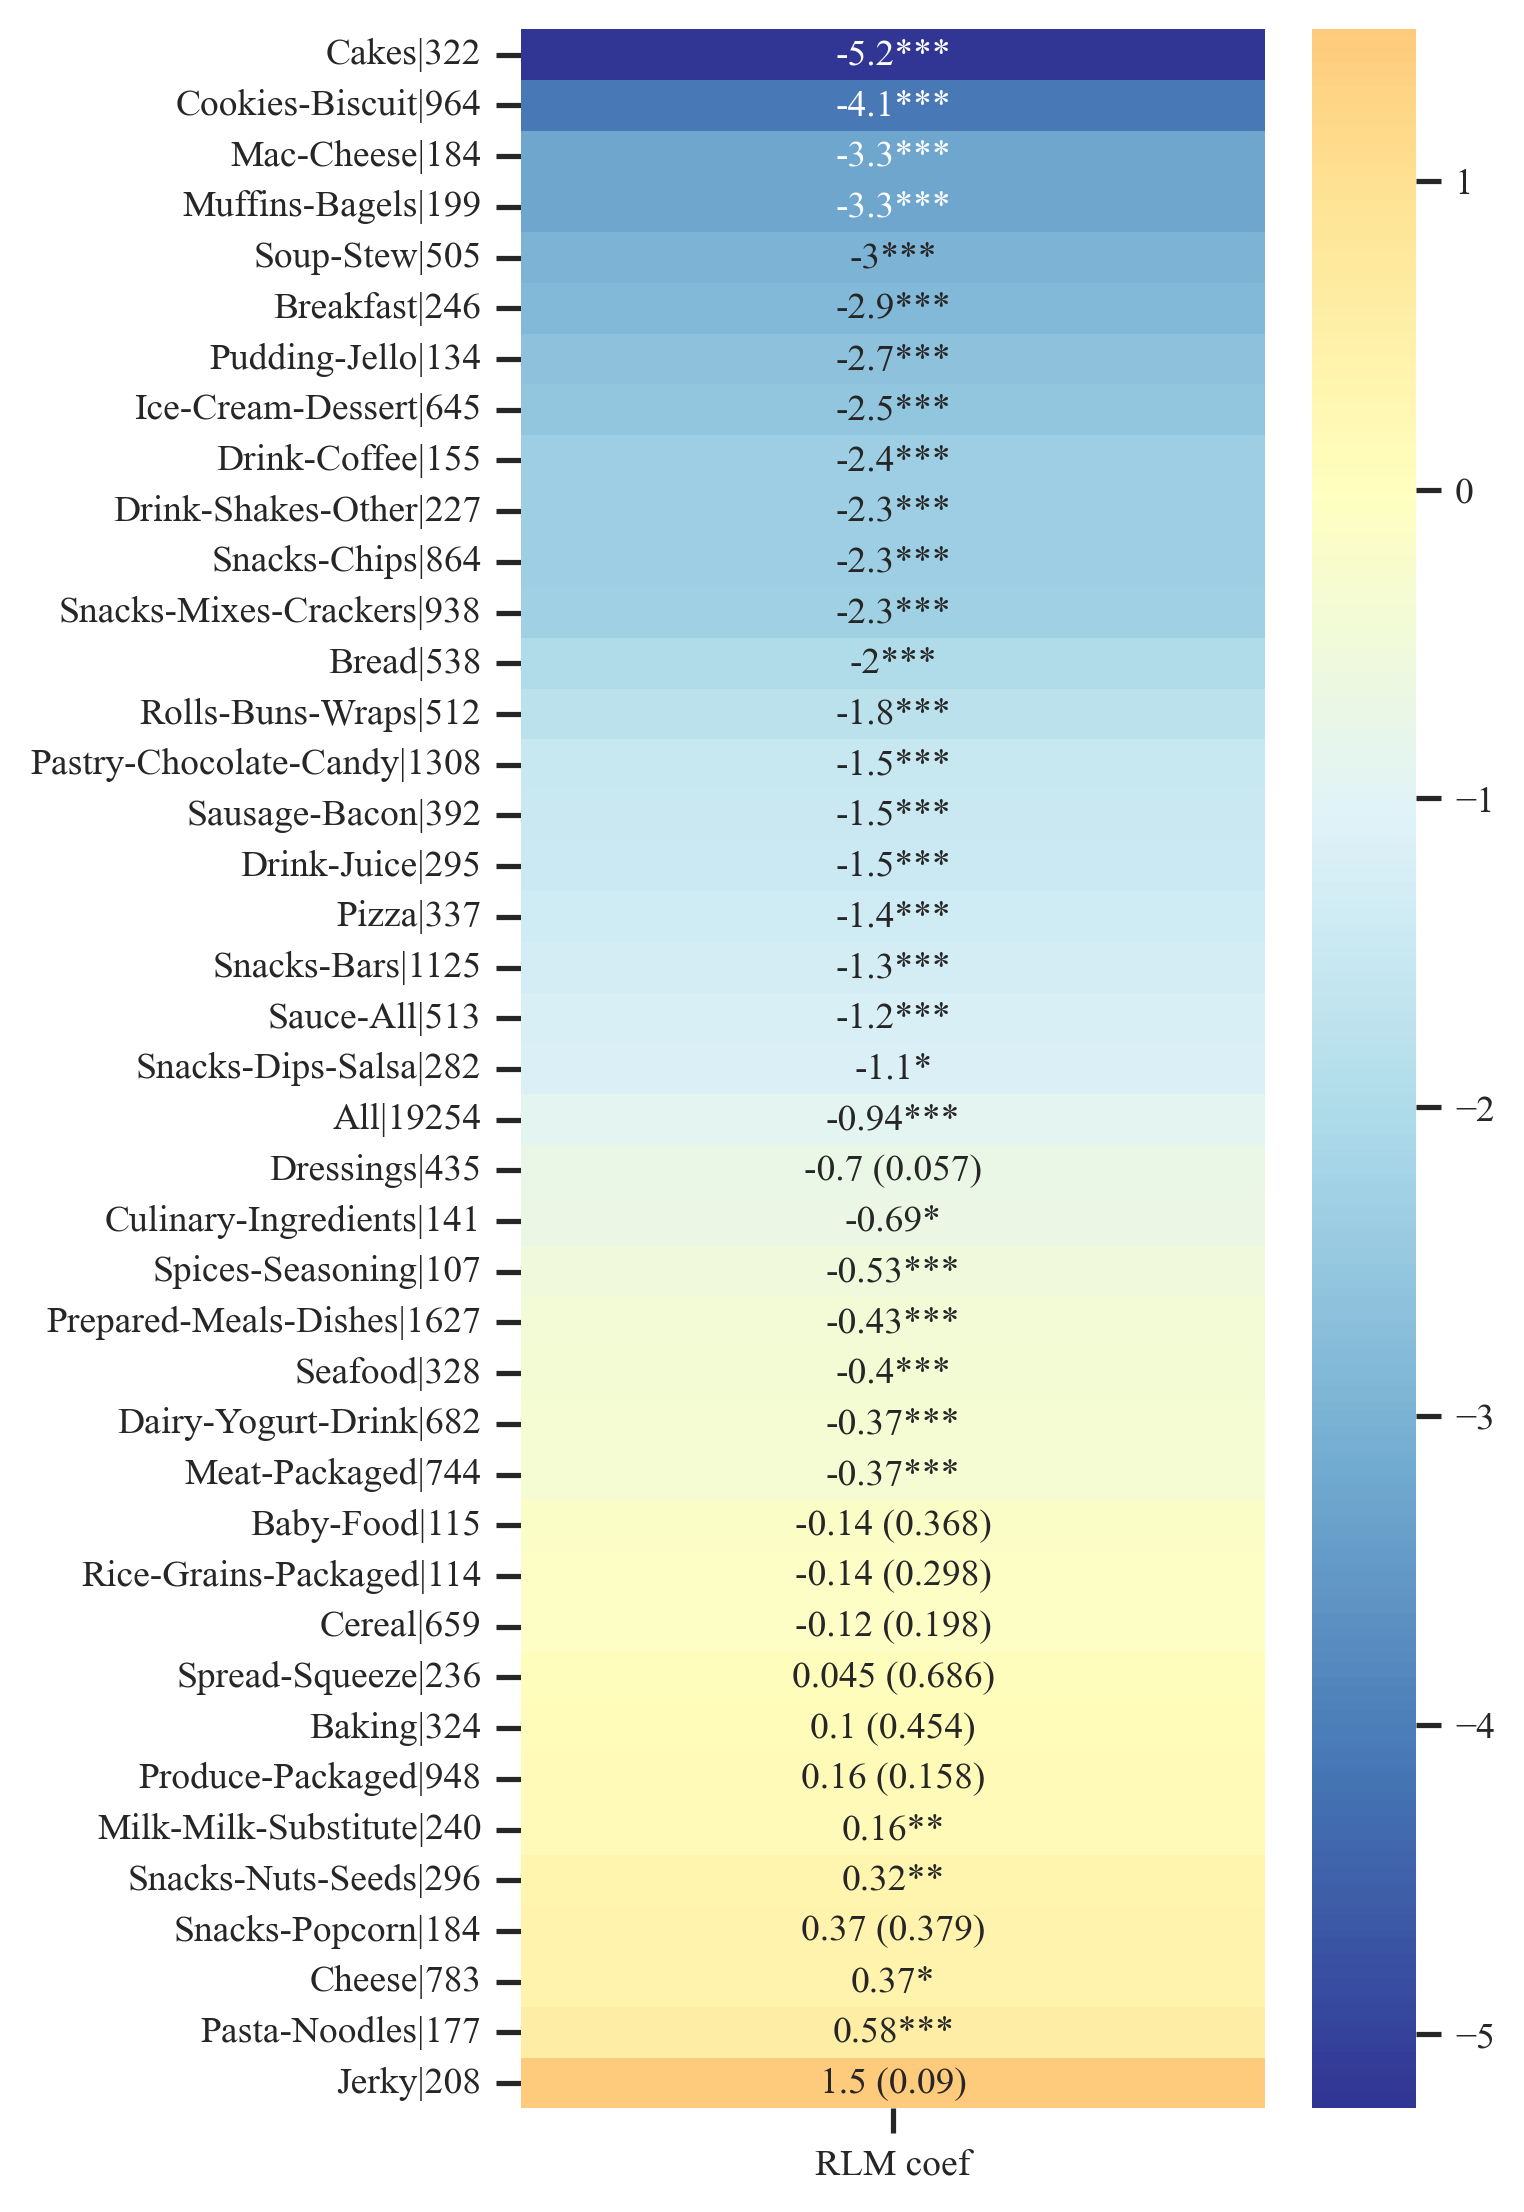

In [21]:
print('esitmate_perc_change_apply_log:', esitmate_perc_change_apply_log)

set_blank_for_not_sig = False

reg_results_c = reg_results.copy()

if set_blank_for_not_sig:
    reg_results_c.loc[reg_results_c['RLM pvalue'] > 0.05, 'RLM coef'] = None

res = grocery_base.plot_correlation_matrix(
    cat_corr_df=reg_results_c, 
    filter_min_num_items_in_category=100,
    cols_heatmap = ['RLM coef'], #, 'OLS coef'
#     title=f'PricePerCal ~ FPro | FPro min: {fpro_min}\nRegression Ordinary Least Squares & Robust Linear Model', 
    title=None, # to hide title
    figsize=(4, 9),
    font_size=9,
    add_count_items=True, 
#     vmin_vmax=(-0.15, 0.15)
)

g = res['g']
cat_corr_df = res['cat_corr_df']

if set_blank_for_not_sig:
    # the null ones (not sig) wont have a text in g.axes.texts
    cat_corr_df = cat_corr_df[cat_corr_df['RLM pval stars'] != ''].reset_index(drop=True)

if True:
    for i in range(len(g.axes.texts)):
        p_val = cat_corr_df['RLM pvalue'].round(3).values[i]
        if p_val >= 0.05:
            g.axes.texts[i]._text += '' + cat_corr_df['RLM pval stars'].values[i] + ' (' + str(p_val) + ')'
        else:
            g.axes.texts[i]._text += '' + cat_corr_df['RLM pval stars'].values[i] 
        pass

plt.savefig('output/figS8.pdf')

# Figure 3a

n_boot: 1000


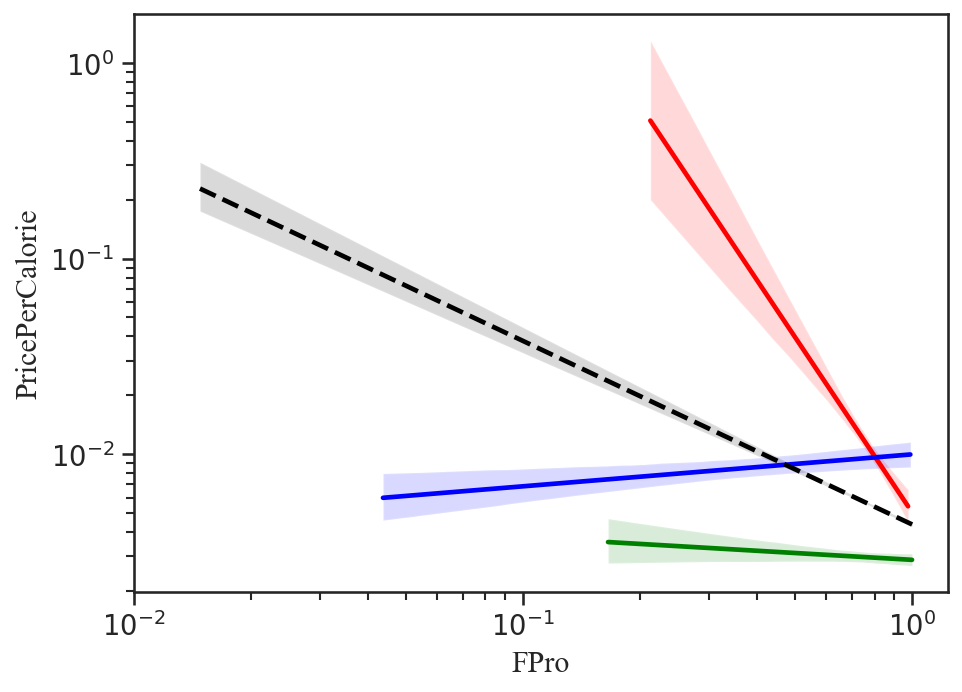

In [22]:
set_fonts(font_size =12, font_scale=1.2)

fig = plt.figure(figsize=(7, 5), dpi=150)
fpro_min = 0
n_boot = [1000, 10][0]

col_log = ['', ' log'][1]

print('n_boot:', n_boot)

data_df = gdb_conv_df[(gdb_conv_df[col_categories] == 'soup-stew') & (gdb_conv_df['f_FPro'] >= fpro_min)].copy()
data_df['f_FPro'+col_log] = data_df['f_FPro'].apply(np.log)
data_df['price percal'+col_log] = data_df['price percal'].apply(np.log)
ax = sns.regplot(x='f_FPro'+col_log, y='price percal'+col_log, data=data_df, n_boot=n_boot,
                 scatter=False, robust=True, x_estimator=np.mean, color='red')

# ['cakes', 'cookies-biscuit'][0]
data_df = gdb_conv_df[(gdb_conv_df[col_categories] == 'cereal') & (gdb_conv_df['f_FPro'] >= fpro_min)].copy()
data_df['f_FPro'+col_log] = data_df['f_FPro'].apply(np.log)
data_df['price percal'+col_log] = data_df['price percal'].apply(np.log)
sns.regplot(x='f_FPro'+col_log, y='price percal'+col_log, data=data_df, n_boot=n_boot,
            scatter=False, robust=True, x_estimator=np.mean, color='green', ax=ax)

# mac-cheese  pasta-noodles
data_df = gdb_conv_df[(gdb_conv_df[col_categories] == 'milk-milk-substitute') & (gdb_conv_df['f_FPro'] >= fpro_min)].copy()
data_df['f_FPro'+col_log] = data_df['f_FPro'].apply(np.log)
data_df['price percal'+col_log] = data_df['price percal'].apply(np.log)
sns.regplot(x='f_FPro'+col_log, y='price percal'+col_log, data=data_df,n_boot=n_boot,
            scatter=False, robust=True, x_estimator=np.mean, color='blue', ax=ax)

data_df = gdb_conv_df[(gdb_conv_df['f_FPro'] >= fpro_min)].copy()
data_df['f_FPro'+col_log] = data_df['f_FPro'].apply(np.log)
data_df['price percal'+col_log] = data_df['price percal'].apply(np.log)
sns.regplot(x='f_FPro'+col_log, y='price percal'+col_log, data=data_df, n_boot=n_boot, line_kws={'linestyle': '--'},
            scatter=False, robust=True, x_estimator=np.mean, color='black', ax=ax)

ax.set(xlabel='FPro', ylabel='PricePerCalorie') # FPro

ax.set_xticks([np.log(10**0), np.log(10**-1), np.log(10**-2)])
ax.set_xticklabels(['$10^{0}$','$10^{-1}$','$10^{-2}$'])

ax.xaxis.set_minor_locator(matplotlib.ticker.FixedLocator(
    [
        np.log(0.02), np.log(0.03), np.log(0.04), np.log(0.05), np.log(0.06), np.log(0.07), np.log(0.08), np.log(0.09),
        np.log(0.2), np.log(0.3), np.log(0.4), np.log(0.5), np.log(0.6), np.log(0.7), np.log(0.8), np.log(0.9),
    ]
))

ax.set_yticks([np.log(10**-2), np.log(10**-1), np.log(10**0) ])
ax.set_yticklabels(['$10^{-2}$','$10^{-1}$','$10^{0}$'])

ax.yaxis.set_minor_locator(matplotlib.ticker.FixedLocator(
    [
        np.log(0.002), np.log(0.003), np.log(0.004), np.log(0.005), np.log(0.006), np.log(0.007), np.log(0.008), np.log(0.009),
        np.log(0.02), np.log(0.03), np.log(0.04), np.log(0.05), np.log(0.06), np.log(0.07), np.log(0.08), np.log(0.09),
        np.log(0.2), np.log(0.3), np.log(0.4), np.log(0.5), np.log(0.6), np.log(0.7), np.log(0.8), np.log(0.9),
    ]
))

plt.savefig('output/fig3_A.pdf', dpi=300, bbox_inches='tight')

In [23]:
gdb_conv_df['price percal'].describe()

count    19254.000000
mean     0.012851    
std      0.114661    
min      0.000013    
25%      0.002877    
50%      0.005542    
75%      0.010969    
max      14.695269   
Name: price percal, dtype: float64

### Calculate Change in Price per Cal when going from minimally processed to ultra processed

In [24]:
def cal_price_change_df(col_FPro, col_price):
    col_price_type = ['price percal', 'price'][0]
    
    price_change_df = []

    target_perc = 10
    rlm_weight_cut_off = [None, 1.0][0]
    
    print('col_FPro:', col_FPro)
    print('col_price_type:', col_price_type)
    print('col_price:', col_price)

    for cat in ['ALL'] +  list(gdb_conv_df[col_categories].unique()):

#         if cat != 'milk-milk-substitute':
#             continue

        if cat == 'ALL':
            cat_price_df = gdb_conv_df
        else:
            cat_price_df = gdb_conv_df[gdb_conv_df[col_categories] == cat]

        gdb_price_cat_df = (
            cat_price_df[
    #             (gdb_conv_df[col_categories] == cat) & 
                (~cat_price_df[col_price_type].isnull())
            ]
            .sort_values(by='f_FPro', ascending=True)
            .reset_index(drop=True)
        )

        gdb_price_cat_df['f_FPro Standardized'] = gdb_price_cat_df['f_FPro'].apply(
            lambda fpro: grocery_base.normalizeBetweenTwoRanges(
                val=fpro, 
                minVal=gdb_price_cat_df['f_FPro'].min(), 
                maxVal=gdb_price_cat_df['f_FPro'].max(), 
                newMin=0,
                newMax=1
            )
        )
        
        gdb_price_cat_df[col_price_type + ' Standardized'] = gdb_price_cat_df[col_price_type].apply(
            lambda fpro: grocery_base.normalizeBetweenTwoRanges(
                val=fpro, 
                minVal=gdb_price_cat_df[col_price_type].min(), 
                maxVal=gdb_price_cat_df[col_price_type].max(), 
                newMin=0,
                newMax=1
            )
        )

        ''''''
        x_vals = gdb_price_cat_df[col_FPro]
        X = np.c_[np.ones(len(x_vals)), x_vals]

        y = gdb_price_cat_df[col_price]

        rlm_model = sm.RLM(y, X, sm.robust.norms.HuberT())

        rlm_results = rlm_model.fit()

        gdb_price_cat_df['rlm weights'] = rlm_results.weights

        num_outliers = sum(gdb_price_cat_df['rlm weights'] < 1.0)

        if False:
            print('cat: {} num: {} outliers: {}'.format(
                cat,
                len(gdb_price_cat_df),
                num_outliers
            ))

    #     gdb_price_cat_df = gdb_price_cat_df[gdb_price_cat_df['rlm weights'] >= rlm_weight_cut_off]
        
        # USE RLM weight for sure, otherwise the effect is driven by outliers...
        if True:
            gdb_price_cat_df[col_price] = gdb_price_cat_df[col_price] * gdb_price_cat_df['rlm weights']

        ''''''

        num_perc = int(np.ceil((len(gdb_price_cat_df) * target_perc) / 100))

        least_fpro_df = gdb_price_cat_df.head(num_perc)
        highest_fpro_df = gdb_price_cat_df.tail(num_perc)

        least_FPro_price_avg = least_fpro_df[col_price].mean()
        highest_FPro_price_avg = highest_fpro_df[col_price].mean()

        price_change_df.append({
                'cat': cat,
                'count items': len(gdb_price_cat_df),
                'RLM weight min': rlm_weight_cut_off,
                'RLM num outliers (weight < 1)': num_outliers,
                'RLM coef': rlm_results.params[1],
                'RLM pvalue': round(rlm_results.pvalues[1], 6),
                'target_perc': target_perc,
                'num items target_perc': num_perc,
                'least FPro avg': least_fpro_df[col_FPro].mean(),
                'highest FPro avg': highest_fpro_df[col_FPro].mean(),
                'least price avg': least_FPro_price_avg,
                'highest prcie avg': highest_FPro_price_avg,
                'price perc change least to highest FPro': ((highest_FPro_price_avg - least_FPro_price_avg) / least_FPro_price_avg) * 100
            }
        )

    #     break
        pass
    
#     gdb_conv_df[col_categories].unique()
#     gdb_price_cat_df[[col_categories, 'store', 'name', 'brand', col_price, col_FPro]].tail(num_perc)

    price_change_df = pd.DataFrame(price_change_df).sort_values('price perc change least to highest FPro').reset_index(drop=True)
    
    return price_change_df

# price_change_df = cal_price_change_df(col_FPro='f_FPro Standardized')
price_change_df = cal_price_change_df(col_FPro='f_FPro', col_price='price percal')
#price_change_df[price_change_df['count items'] > 0]
# price_change_df[price_change_df['cat'] == 'milk-milk-substitute']

col_FPro: f_FPro
col_price_type: price percal
col_price: price percal


In [25]:
price_change_standardized_df = cal_price_change_df(col_FPro='f_FPro Standardized', col_price='price percal Standardized')

col_FPro: f_FPro Standardized
col_price_type: price percal
col_price: price percal Standardized


In [26]:
price_change_both_df = pd.merge(
    price_change_df,
    price_change_standardized_df[['cat', 'least FPro avg', 'highest FPro avg', 'least price avg',
                                 'highest prcie avg', 'price perc change least to highest FPro']].rename(columns={
        'least FPro avg': 'least FPro avg Standardized',
        'highest FPro avg': 'highest FPro Standardized',
        'least price avg': 'least price avg Standardized',
        'highest prcie avg': 'highest prcie avg Standardized',
        'price perc change least to highest FPro': 'price perc change least to highest FPro Standardized'
    }),
    on='cat'
).sort_values('price perc change least to highest FPro Standardized').reset_index(drop=True)

#price_change_both_df[price_change_both_df['count items'] > 0]

# Figure 3e

esitmate_perc_change_apply_log: False


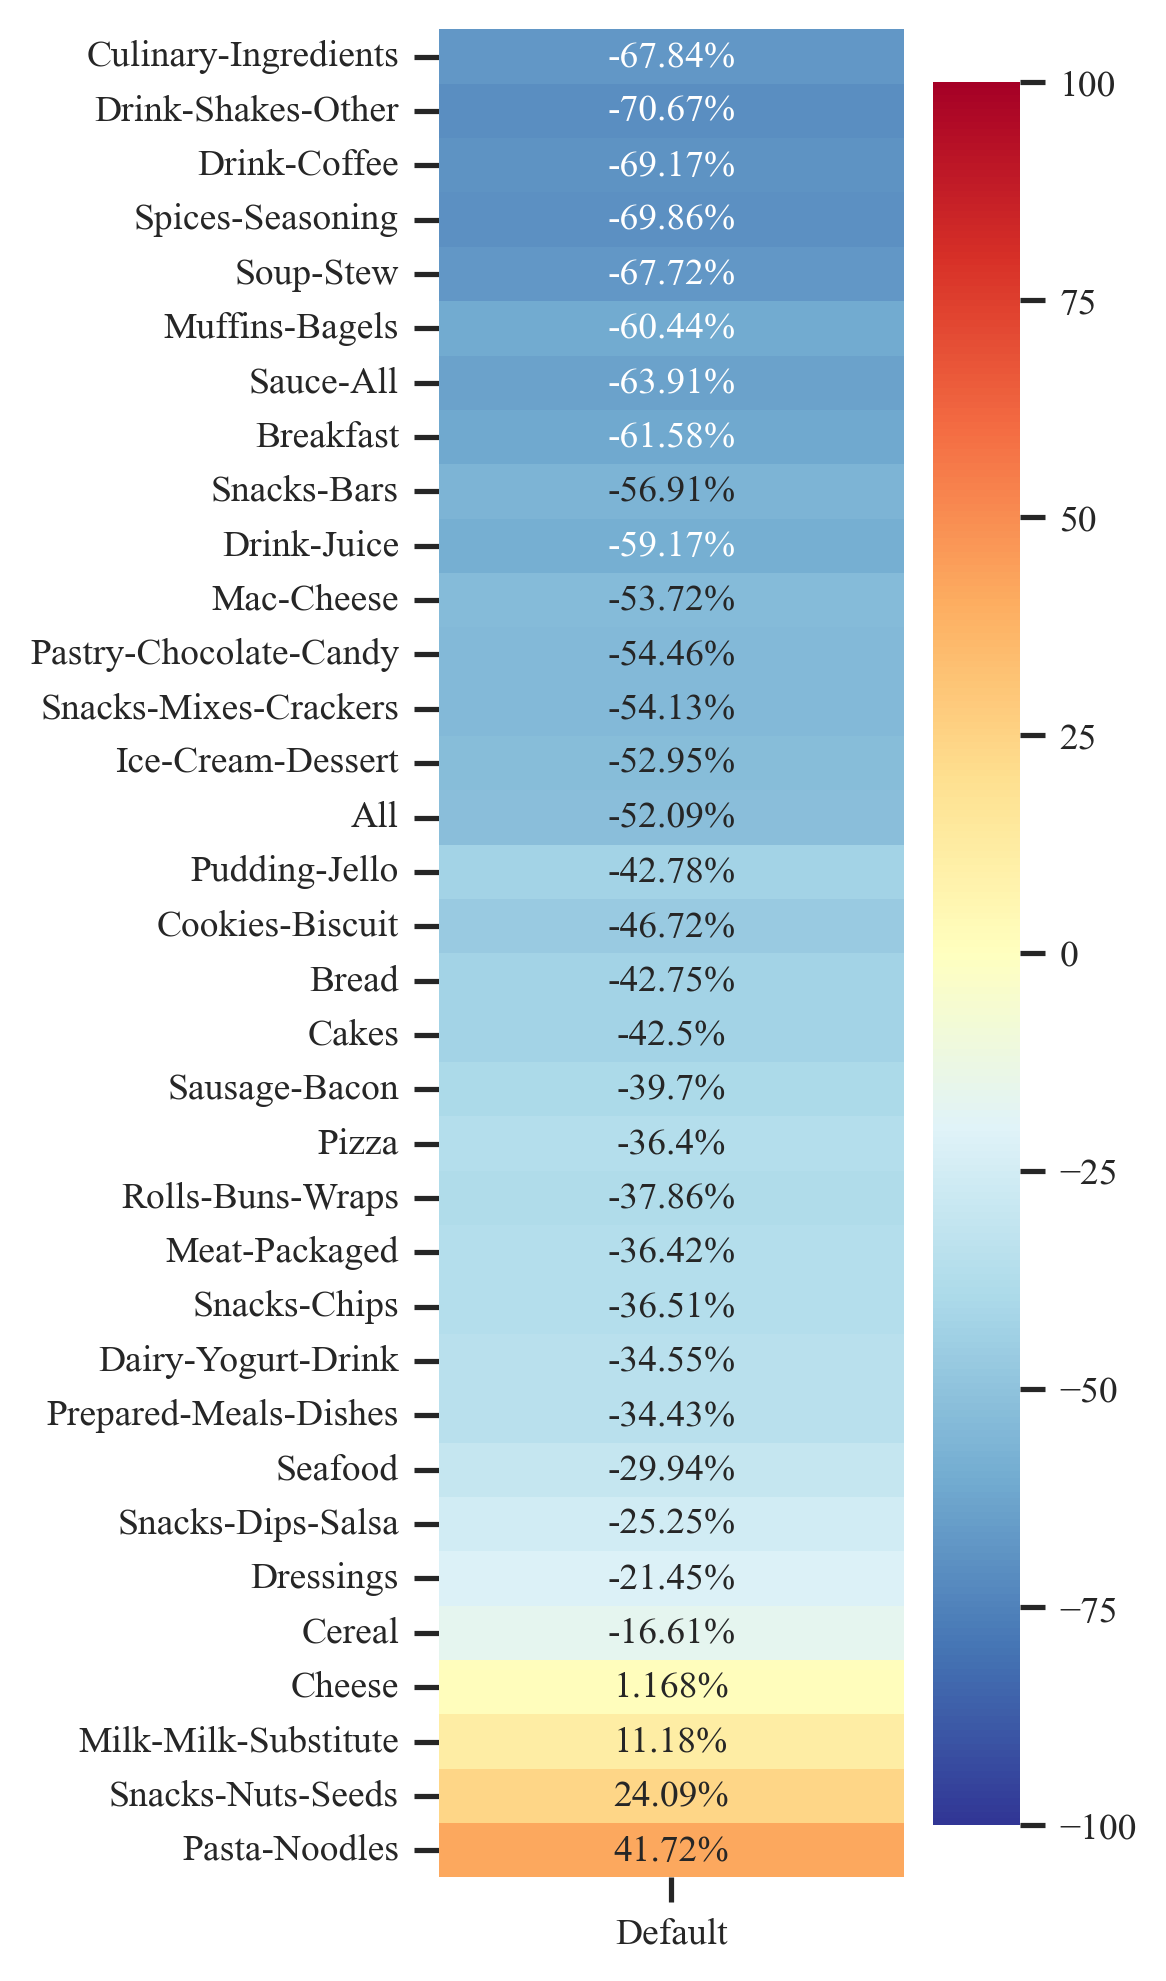

In [27]:
print('esitmate_perc_change_apply_log:', esitmate_perc_change_apply_log)

col_plot = 'price perc change least to highest FPro'
col_plot_standardized = 'price perc change least to highest FPro Standardized'

price_change_results_df = price_change_both_df.copy()
# reg_results_c.loc[reg_results_c['RLM pvalue'] > 0.05, col_plot] = None

price_change_results_df = price_change_results_df[  
#     (~price_change_results_df['cat'].isin(['pasta-noodles'])) & 
    (price_change_results_df['RLM pvalue'] < 0.05)
].reset_index(drop=True)

res = grocery_base.plot_correlation_matrix(
    cat_corr_df=price_change_results_df, 
    filter_min_num_items_in_category=100,
    cols_heatmap = [col_plot], #, 'OLS'
#     cols_heatmap = [col_plot_standardized, col_plot], #, 'OLS'
#     title=f'PricePerCal ~ FPro | FPro min: {fpro_min}\nRegression Ordinary Least Squares & Robust Linear Model', 
    title=None, # to hide title
    figsize=(2.5, 8), # 1.5
    font_size=9,
    add_count_items=False, 
    vmin_vmax=(-100, 100),
#     xticklabels=['Standardized', 'Default'],
    xticklabels=['Default'],
#     vmin_vmax=(None, None)
    fmt='.4g',
    export_path='output/fig3_E.pdf'
)

g = res['g']
cat_corr_df = res['cat_corr_df']

# the null ones (not sig) wont have a text in g.axes.texts
# cat_corr_df = cat_corr_df[cat_corr_df['RLM pval stars'] != ''].reset_index(drop=True)

for i in range(len(g.axes.texts)):
    g.axes.texts[i]._text += '%'# + cat_corr_df['RLM pval stars'].values[i]
    pass

# Figure 3b-d

selected_cat: soup-stew
len BEFORE filtering num records in each bin/store: 502
len AFTER filtering num records in each bin/store: 497
soup-stew | corr: -0.52 num product: 501/622
Predicted:  0.7  FPro -> -4.248384068975417
Predicted:  1.0  FPro -> -5.28811179989426


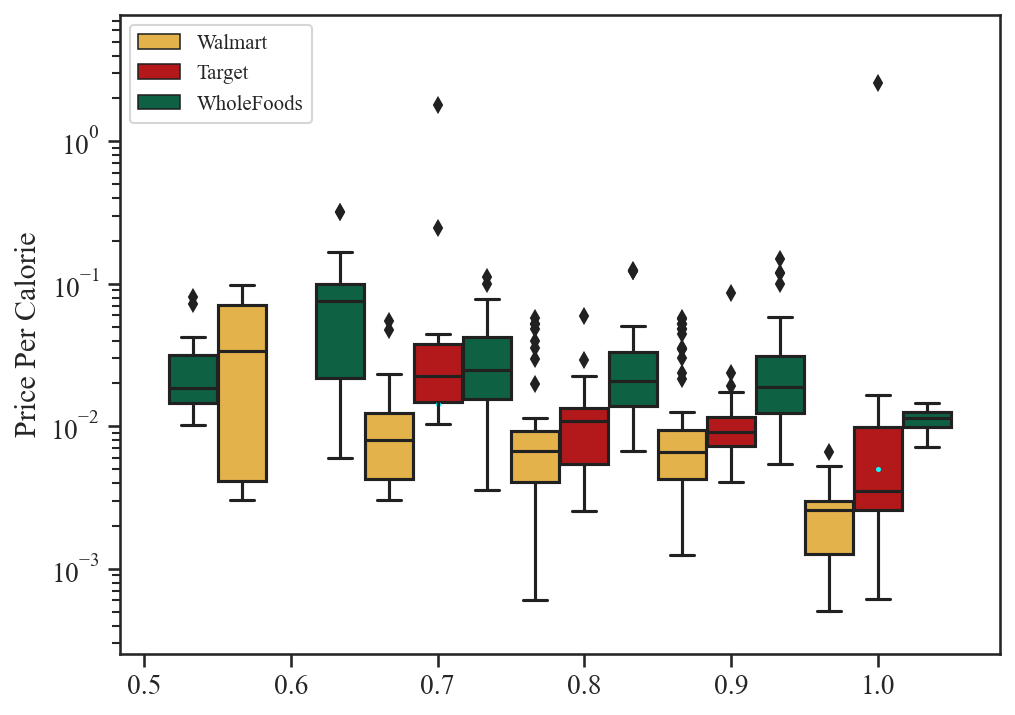

In [37]:
set_fonts()

selected_cat = 'soup-stew' #produces Figure 3b
#selected_cat = 'cereal' #produces Figure 3c
#selected_cat = 'milk-milk-substitute' #produces Figure 3d

print('selected_cat:', selected_cat)

data_df = gdb_conv_df[gdb_conv_df[col_categories] == selected_cat].reset_index(drop=True)

FPro_bin_size = 0.1

# data_df['price percal'] = data_df['price percal'].apply(np.log)

p_res = grocery_base.plot_price_per_cal(
    n_label_x_pad={'Walmart': -0.3, 'Target': 0.05, 'WholeFoods': +0.35},
    figsize=(7, 5), # for figures
    dpi=150, col_FPro='f_FPro', col_yaxis='price percal',
    FPro_bin_size=FPro_bin_size, store_compare_data_df=data_df, remove_legend=False,
    min_FPro_filter= 0.4, # for figures
    title=selected_cat, width_box=1.0,
    min_num_records_in_each_store_bin=4, print_n_on_plot=False, verbose=False
)

def draw_pred_point(FPro, cat):  
#     USE FILE "price_reg.xlsx"
    coef_noTransformation = {'cereal': -0.000955424259041369,'soup-stew':-0.0491247752455035, 'milk-milk-substitute': 0.00369285247256148}
    const_noTransformation = {'cereal': 0.0040942003729359,'soup-stew':0.0524416497358708, 'milk-milk-substitute': 0.00826909109620743}
#     USE FILE "price_reg_log_log.xlsx"
    coef = {'cereal': -0.122714987911472,'soup-stew':-2.91505682859921, 'milk-milk-substitute': 0.163476110870409}
    const = {'cereal': -5.85759456667673,'soup-stew':-5.28811179989426, 'milk-milk-substitute': -4.60703125978466}
    
    if cat not in coef:
        print('[ERROR] DONT HAVE coef to draw a point on the fitted line for cat:', cat)
        return

    FPro_to_box_x = {0.5:1, 0.6:2, 0.7:3, 0.8:4, 0.9:5, 1.0:6}

    pred_price = coef[cat] * np.log(FPro) + const[cat]
    print('Predicted: ', FPro, ' FPro ->', pred_price)

    line_point = (FPro_to_box_x[FPro], np.exp(pred_price))

    plt.scatter(line_point[0], line_point[1], marker='o', s=2, color='aqua')
    
    return line_point

draw_pred_point(FPro=0.7, cat=selected_cat)
draw_pred_point(FPro=1.0, cat=selected_cat)

plt.savefig('output/fig3_D.pdf', bbox_inches='tight')


In [38]:
#selected_cat = 'soup-stew' #produces Figure 3b
selected_cat = 'cereal' #produces Figure 3c
#selected_cat = 'milk-milk-substitute' #produces Figure 3d

data_df = gdb_conv_df[gdb_conv_df[col_categories] == selected_cat].reset_index(drop=True)

In [39]:
store_compare_data_df=data_df
num_initial_products = len(store_compare_data_df)

col_yaxis='price percal'
min_FPro_filter= 0.4
store_compare_data_df = store_compare_data_df.replace([np.inf, -np.inf], np.nan)
store_compare_data_df = (
    store_compare_data_df[~(store_compare_data_df[col_yaxis].isnull())]
    .reset_index(drop=True)
)

store_compare_data_df = store_compare_data_df[store_compare_data_df[col_FPro] >= min_FPro_filter]

col_bin = 'FPro bin'
store_compare_data_df[col_bin] = -1

bin_begin = 0
for bin_end in np.arange(FPro_bin_size, 1.00 + FPro_bin_size, FPro_bin_size):
    if bin_end > 1:
        bin_end = 1.0

    mask_bin = (store_compare_data_df[col_FPro] >= bin_begin) & (store_compare_data_df[col_FPro] < bin_end)

    # print('bin_begin:', bin_begin, 'bin_end:', bin_end)
    store_compare_data_df.loc[mask_bin, col_bin] = round(bin_end, 4)

    bin_begin = bin_end
    pass

In [40]:
store_compare_data_df.keys()

Index(['harmonized single category', 'count_products_category', 'original_ID',
       'name', 'store', 'brand', 'f_FPro', 'f_FPro_P', 'f_min_FPro',
       'f_std_FPro', 'f_FPro_class', 'price', 'price percal', 'package_weight',
       'ingredientList', 'has10_nuts', 'is_Nuts_Converted_100g', 'Protein',
       'Total Fat', 'Carbohydrate', 'Sugars, total', 'Fiber, total dietary',
       'Calcium', 'Iron', 'Sodium', 'Vitamin C', 'Cholesterol',
       'Fatty acids, total saturated', 'Total Vitamin A', 'FPro bin'],
      dtype='object')

# Figure S9

selected_cat: pasta-noodles
len BEFORE filtering num records in each bin/store: 177
len AFTER filtering num records in each bin/store: 156
pasta-noodles | corr: 0.129 num product: 162/253
[ERROR] DONT HAVE coef to draw a point on the fitted line for cat: pasta-noodles
[ERROR] DONT HAVE coef to draw a point on the fitted line for cat: pasta-noodles


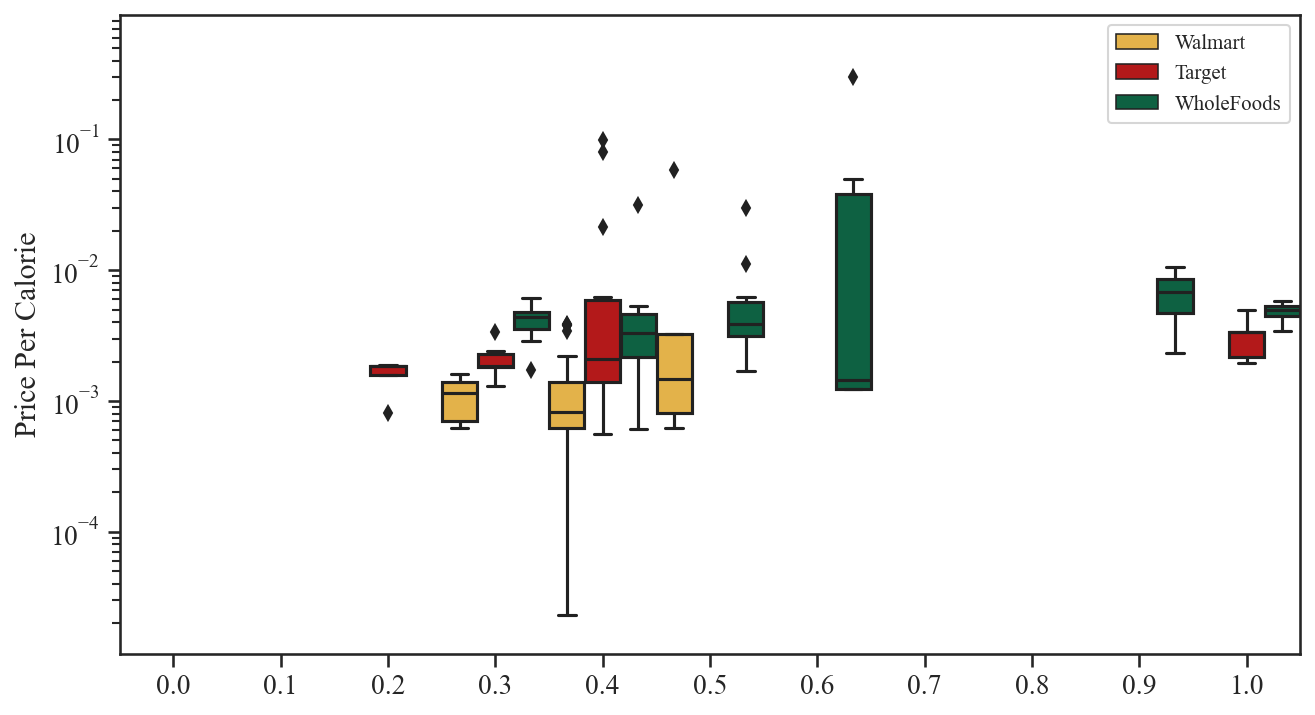

In [42]:
set_fonts()

selected_cat = 'pasta-noodles'

print('selected_cat:', selected_cat)

data_df = gdb_conv_df[gdb_conv_df[col_categories] == selected_cat].reset_index(drop=True)

FPro_bin_size = 0.1

# data_df['price percal'] = data_df['price percal'].apply(np.log)

p_res = grocery_base.plot_price_per_cal(
    n_label_x_pad={'Walmart': -0.3, 'Target': 0.05, 'WholeFoods': +0.35},
    figsize=(9, 5),
    dpi=150, col_FPro='f_FPro', col_yaxis='price percal',
    FPro_bin_size=FPro_bin_size, store_compare_data_df=data_df, remove_legend=False,
    min_FPro_filter= 0.0,
    title=selected_cat, width_box=1.0,
    min_num_records_in_each_store_bin=4, print_n_on_plot=False, verbose=False
)

def draw_pred_point(FPro, cat):  
#     USE FILE "price_reg.xlsx"
    coef_noTransformation = {'cereal': -0.000955424259041369,'soup-stew':-0.0491247752455035, 'milk-milk-substitute': 0.00369285247256148}
    const_noTransformation = {'cereal': 0.0040942003729359,'soup-stew':0.0524416497358708, 'milk-milk-substitute': 0.00826909109620743}
#     USE FILE "price_reg_log_log.xlsx"
    coef = {'cereal': -0.122714987911472,'soup-stew':-2.91505682859921, 'milk-milk-substitute': 0.163476110870409}
    const = {'cereal': -5.85759456667673,'soup-stew':-5.28811179989426, 'milk-milk-substitute': -4.60703125978466}
    
    if cat not in coef:
        print('[ERROR] DONT HAVE coef to draw a point on the fitted line for cat:', cat)
        return

    FPro_to_box_x = {0.5:1, 0.6:2, 0.7:3, 0.8:4, 0.9:5, 1.0:6}

    pred_price = coef[cat] * np.log(FPro) + const[cat]
    print('Predicted: ', FPro, ' FPro ->', pred_price)

    line_point = (FPro_to_box_x[FPro], np.exp(pred_price))

    plt.scatter(line_point[0], line_point[1], marker='o', s=2, color='aqua')
    
    return line_point

draw_pred_point(FPro=0.7, cat=selected_cat)
draw_pred_point(FPro=1.0, cat=selected_cat)

plt.savefig('output/figS9.pdf', bbox_inches='tight')
